In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import defaultdict
import os

In [2]:
def show_weights(filename):
    vals = {}
    actions = 'up right down left'.split()
    with open(filename, 'rb') as file:
        state_dict = torch.load(file)
    for key, value in state_dict.items():
        # vals[key+".max"] = value.max().item()
        # vals[key+".min"] = value.min().item()
        for act, row in zip(actions, value.numpy().round(2)):
            vals[f"{key}.{act}"] = row
    return vals

def get_results(filename, rolling_len=200):
    with open(filename, "rb") as file:
        results = pickle.load(file)
    print(len(results), len(results[0]))
    dirname = os.path.dirname(filename)
    rolled_up = []
    frame = []
    for seed, result in enumerate(results):
        r = pd.Series(result).rolling(rolling_len, min_periods=1).mean().dropna()
        r = list(r)
        rolled_up.append(r)
        weights_file = os.path.join(dirname, f"weights.{seed}.pth")
        vals = show_weights(weights_file)
        vals["perf"] = r[-1]
        frame.append(vals)
    frame = pd.DataFrame.from_records(frame)
    display(frame.sort_values("perf", ascending=False))
    rolled_up = np.array(rolled_up)

    avg_rewards = np.median(rolled_up, 0)
    min_rewards = rolled_up.min(0)
    max_rewards = rolled_up.max(0)
    std_rewards = rolled_up.std(0)

    bot = np.maximum(avg_rewards - std_rewards, min_rewards)
    top = np.minimum(avg_rewards + std_rewards, max_rewards)
    return avg_rewards, bot, top


In [3]:
vals = defaultdict(int)
for seed in range(10):
    # print(seed)
    with open(f"saves/reinforce/tiny/weights.{seed}.pth", 'rb') as file:
        state_dict = torch.load(file)
    for key, value in state_dict.items():
        # print("\t", key, value.max(), value.min())
        vals[key+".max"] = max(vals[key+".max"], value.max().item())
        vals[key+".min"] = min(vals[key+".min"], value.min().item())

print("Reinforce")
for key, value in vals.items():
    print(key, value)


Reinforce
fc.weight.max 0.5456724762916565
fc.weight.min -0.8427281379699707
fc.bias.max 0.8449665904045105
fc.bias.min -0.7622199058532715


In [4]:
vals = defaultdict(int)
for seed in range(10):
    # print(seed)
    with open(f"saves/sf_reinforce/tiny/weights.{seed}.pth", 'rb') as file:
        state_dict = torch.load(file)
    for key, value in state_dict.items():
        vals[key+".max"] = max(vals[key+".max"], value.max().item())
        vals[key+".min"] = min(vals[key+".min"], value.min().item())

print("SPSA")
for key, value in vals.items():
    print(key, value)


SPSA
fc.weight.max 0.5448506474494934
fc.weight.min -0.5521352291107178
fc.bias.max 0.44599175453186035
fc.bias.min -0.47158095240592957


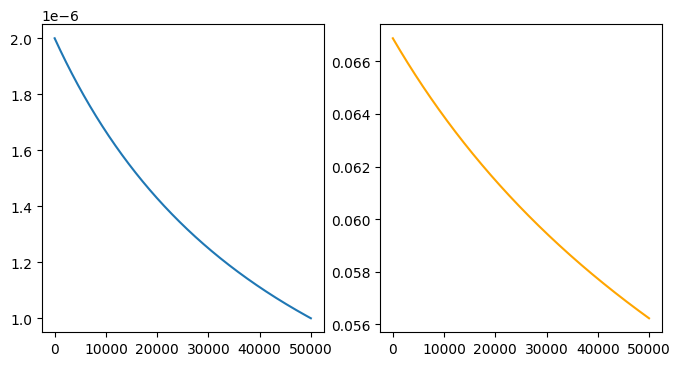

In [5]:
def get_delta(episode):
    return (2e-5 / (1 + episode * 2e-5)) ** 0.25


def get_alpha(episode):
    return 2e-6 / (1 + episode * 2e-5)


episode = np.arange(50000)
alpha = get_alpha(episode)
delta = get_delta(episode)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(episode, alpha)
ax[1].plot(episode, delta, color="orange")


sf_reinforce tiny
10 50000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
0,"[-0.12, 0.21, -0.4, -0.25, -0.07, -0.12]","[0.17, 0.45, -0.08, 0.07, -0.1, 0.11]","[-0.3, -0.28, -0.11, 0.17, 0.23, 0.4]","[-0.37, -0.34, 0.14, 0.16, -0.08, 0.16]",-0.16,0.05,0.37,-0.47,13.469798
1,"[0.2, -0.31, -0.14, -0.01, -0.36, 0.05]","[-0.06, 0.4, 0.13, -0.14, 0.02, 0.15]","[0.28, -0.11, 0.12, 0.14, 0.07, 0.18]","[0.34, 0.18, -0.11, -0.16, -0.14, -0.22]",-0.23,0.03,0.35,0.18,13.415948
2,"[0.04, -0.12, 0.01, -0.25, 0.14, -0.05]","[0.13, -0.09, 0.18, -0.14, 0.1, 0.33]","[-0.1, 0.43, 0.1, 0.44, 0.22, -0.16]","[-0.24, 0.21, -0.47, -0.2, -0.06, -0.07]",-0.02,0.15,-0.10,-0.32,13.303138
8,"[0.07, 0.17, 0.38, -0.22, 0.01, -0.21]","[0.31, -0.38, 0.04, -0.29, 0.43, 0.38]","[-0.15, -0.23, -0.3, 0.54, 0.32, -0.01]","[0.01, -0.24, -0.4, -0.14, -0.38, -0.08]",0.12,-0.27,0.01,-0.09,13.237013
4,"[0.09, -0.09, -0.3, -0.22, -0.41, -0.51]","[0.46, 0.38, 0.09, 0.23, -0.16, -0.19]","[0.34, -0.02, 0.1, 0.36, 0.27, -0.11]","[-0.16, -0.42, 0.07, -0.16, -0.04, -0.1]",0.31,-0.05,0.25,0.18,13.192780
3,"[-0.41, -0.34, -0.22, -0.55, -0.03, -0.42]","[0.15, 0.22, 0.14, -0.01, -0.14, 0.21]","[-0.27, -0.23, -0.34, 0.21, -0.28, 0.48]","[0.35, 0.18, 0.03, -0.25, 0.37, -0.46]",-0.22,-0.27,-0.14,0.05,13.190864
5,"[0.22, -0.35, 0.31, 0.26, 0.25, -0.5]","[-0.16, 0.28, -0.5, 0.31, 0.09, 0.41]","[-0.26, 0.07, 0.26, 0.31, 0.41, 0.28]","[-0.47, 0.3, 0.12, -0.11, -0.3, -0.08]",0.27,-0.35,0.10,0.13,13.166023
6,"[-0.05, 0.01, 0.42, -0.03, -0.35, -0.27]","[0.22, 0.43, 0.08, -0.25, -0.03, 0.16]","[-0.0, 0.09, -0.14, 0.37, 0.39, 0.14]","[-0.08, -0.17, -0.35, -0.26, -0.16, 0.11]",0.13,0.03,-0.16,0.19,13.142362
7,"[-0.04, -0.26, 0.13, -0.01, -0.25, -0.31]","[-0.3, 0.28, -0.12, 0.16, 0.27, 0.04]","[-0.1, -0.18, 0.05, 0.13, 0.24, 0.12]","[0.26, -0.47, 0.22, -0.1, 0.22, -0.1]",0.03,0.06,0.45,0.09,13.120663
9,"[-0.03, -0.35, -0.09, 0.14, 0.4, -0.07]","[-0.16, 0.48, -0.02, -0.11, 0.35, 0.16]","[-0.08, -0.11, 0.12, 0.16, 0.07, 0.28]","[-0.15, 0.06, 0.18, 0.16, 0.41, -0.06]",-0.14,-0.28,0.44,0.12,13.053609


two_sided_sf_reinforce tiny
10 50000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
0,"[-0.06, 0.14, -0.36, -0.32, -0.16, -0.08]","[0.04, 0.47, -0.04, 0.08, -0.11, 0.11]","[-0.36, -0.24, -0.1, 0.14, 0.2, 0.45]","[-0.33, -0.27, 0.09, 0.26, -0.11, 0.09]",-0.09,0.06,0.44,-0.42,13.498008
1,"[0.15, -0.25, -0.15, 0.03, -0.41, -0.03]","[-0.05, 0.32, 0.06, -0.08, 0.12, 0.17]","[0.18, -0.17, 0.05, 0.17, 0.09, 0.2]","[0.35, 0.09, -0.16, -0.26, -0.08, -0.25]",-0.19,0.06,0.32,0.20,13.463131
2,"[0.08, -0.1, 0.04, -0.18, 0.14, -0.03]","[0.04, -0.18, 0.17, -0.26, 0.09, 0.4]","[-0.08, 0.34, 0.08, 0.41, 0.17, -0.14]","[-0.22, 0.24, -0.49, -0.21, -0.04, -0.06]",-0.08,0.21,-0.02,-0.30,13.341576
9,"[0.03, -0.31, -0.08, 0.12, 0.3, -0.06]","[-0.17, 0.5, -0.08, -0.06, 0.39, 0.22]","[-0.2, -0.12, 0.1, 0.16, 0.08, 0.34]","[-0.08, -0.0, 0.11, 0.17, 0.3, -0.05]",-0.12,-0.34,0.47,0.18,13.287212
3,"[-0.4, -0.33, -0.18, -0.39, -0.02, -0.37]","[0.23, 0.29, -0.0, 0.07, -0.05, 0.19]","[-0.29, -0.16, -0.28, 0.23, -0.23, 0.46]","[0.28, 0.29, 0.11, -0.25, 0.36, -0.43]",-0.29,-0.27,-0.10,0.05,13.226904
4,"[0.04, 0.03, -0.34, -0.24, -0.41, -0.43]","[0.42, 0.4, 0.06, 0.27, -0.15, -0.21]","[0.37, -0.05, 0.14, 0.39, 0.25, -0.11]","[-0.18, -0.41, -0.01, -0.17, 0.07, -0.08]",0.31,0.05,0.26,0.08,13.213512
8,"[0.01, 0.19, 0.28, -0.33, -0.02, -0.22]","[0.38, -0.34, 0.11, -0.27, 0.37, 0.37]","[-0.2, -0.24, -0.33, 0.55, 0.28, 0.05]","[-0.06, -0.3, -0.34, -0.09, -0.35, -0.06]",0.16,-0.26,-0.05,-0.07,13.208157
7,"[0.01, -0.33, 0.07, 0.0, -0.24, -0.28]","[-0.22, 0.2, -0.15, 0.14, 0.27, 0.06]","[-0.09, -0.17, 0.09, 0.17, 0.25, 0.1]","[0.35, -0.44, 0.28, -0.13, 0.19, -0.1]",-0.02,0.05,0.44,0.05,13.156927
6,"[0.02, -0.02, 0.33, -0.01, -0.24, -0.23]","[0.2, 0.37, 0.09, -0.22, -0.12, 0.27]","[0.11, 0.15, -0.19, 0.34, 0.32, 0.15]","[-0.14, -0.25, -0.32, -0.24, -0.11, 0.12]",0.04,-0.03,-0.19,0.22,13.134519
5,"[0.24, -0.33, 0.32, 0.19, 0.34, -0.4]","[-0.22, 0.39, -0.38, 0.3, 0.09, 0.27]","[-0.35, 0.08, 0.25, 0.29, 0.42, 0.25]","[-0.42, 0.21, 0.11, -0.24, -0.39, -0.03]",0.34,-0.31,0.09,0.09,13.119465


reinforce tiny
10 50000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
0,"[-0.35, -0.06, -0.5, -0.46, -0.38, -0.24]","[0.13, 0.49, -0.03, 0.07, -0.08, 0.04]","[-0.31, -0.27, 0.01, 0.18, 0.3, 0.35]","[-0.48, -0.34, -0.08, 0.19, -0.29, 0.08]",-0.45,0.14,0.70,-0.76,14.036901
9,"[-0.27, -0.55, -0.21, 0.09, 0.0, -0.03]","[-0.04, 0.53, -0.0, -0.02, 0.55, 0.21]","[0.04, 0.06, 0.28, 0.24, 0.25, 0.23]","[-0.33, -0.17, -0.19, -0.07, -0.01, -0.14]",-0.55,-0.23,0.84,-0.22,13.951476
8,"[-0.28, -0.07, 0.05, -0.42, -0.35, -0.25]","[0.45, -0.28, 0.15, -0.28, 0.43, 0.27]","[-0.07, -0.16, -0.21, 0.5, 0.44, -0.01]","[-0.24, -0.51, -0.62, -0.29, -0.53, -0.2]",-0.38,-0.05,0.29,-0.50,13.949587
1,"[-0.21, -0.53, -0.45, -0.14, -0.71, -0.21]","[0.01, 0.34, 0.06, -0.08, 0.13, 0.1]","[0.25, -0.13, 0.14, 0.13, 0.23, 0.13]","[0.2, -0.02, -0.27, -0.34, -0.26, -0.34]",-0.65,0.18,0.54,-0.20,13.923175
4,"[-0.21, -0.15, -0.46, -0.37, -0.63, -0.64]","[0.43, 0.39, -0.0, 0.25, -0.18, -0.23]","[0.39, -0.04, 0.23, 0.4, 0.41, -0.16]","[-0.43, -0.64, -0.34, -0.48, -0.28, -0.3]",-0.20,0.15,0.54,-0.32,13.912299
5,"[-0.05, -0.6, 0.1, 0.01, 0.05, -0.66]","[-0.09, 0.42, -0.41, 0.3, 0.18, 0.2]","[-0.36, 0.05, 0.38, 0.28, 0.51, 0.15]","[-0.75, -0.03, -0.32, -0.62, -0.7, -0.19]",-0.17,-0.13,0.39,-0.38,13.911214
2,"[-0.17, -0.28, -0.17, -0.27, -0.11, -0.2]","[0.19, -0.11, 0.29, -0.23, 0.23, 0.28]","[-0.01, 0.41, 0.19, 0.36, 0.3, -0.13]","[-0.52, -0.01, -0.84, -0.46, -0.4, -0.13]",-0.48,0.53,0.09,-0.72,13.870677
6,"[-0.21, -0.17, 0.04, -0.2, -0.53, -0.37]","[0.3, 0.36, 0.2, -0.23, 0.02, 0.13]","[0.08, 0.13, -0.11, 0.38, 0.43, 0.08]","[-0.28, -0.34, -0.6, -0.44, -0.45, 0.06]",-0.55,0.24,0.10,-0.26,13.870494
7,"[-0.3, -0.55, -0.14, -0.13, -0.48, -0.41]","[-0.14, 0.27, -0.2, 0.15, 0.3, 0.11]","[0.08, -0.1, 0.29, 0.22, 0.5, -0.05]","[0.11, -0.56, 0.1, -0.22, -0.09, -0.11]",-0.30,0.07,0.81,-0.32,13.782356
3,"[-0.61, -0.53, -0.28, -0.51, -0.14, -0.55]","[0.26, 0.27, -0.08, 0.08, -0.02, 0.24]","[-0.31, -0.15, -0.17, 0.21, -0.17, 0.39]","[0.13, 0.12, -0.17, -0.48, -0.0, -0.63]",-0.63,-0.23,0.13,-0.31,13.761291


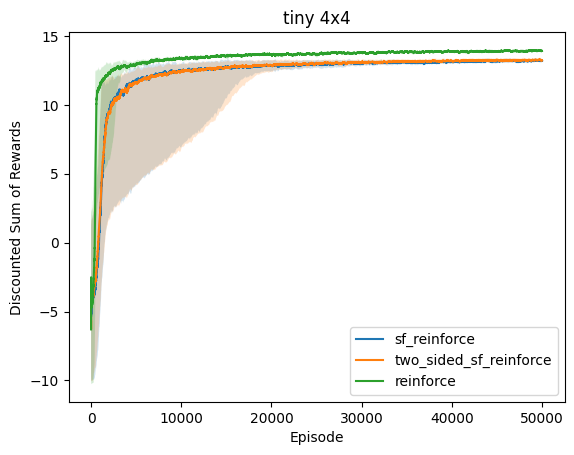

sf_reinforce small
10 100000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
0,"[0.45, -0.36, -0.42, -0.59, 0.01, 0.23]","[-0.46, 1.09, -0.25, -0.46, 0.04, 0.48]","[-0.2, -0.28, -0.25, 0.34, -0.02, 0.85]","[0.2, 0.21, 0.32, -0.02, -0.04, -0.03]",-0.21,0.03,0.53,-0.61,52.202284
4,"[0.13, -0.51, -0.61, 0.03, -0.89, -0.56]","[0.25, 0.5, 0.51, -0.56, -0.19, 0.37]","[0.54, -0.15, 0.12, 0.68, 0.27, -0.09]","[-0.01, -0.09, -0.07, -0.53, 0.28, -0.17]",0.09,0.13,-0.24,-0.23,51.601250
5,"[0.16, -0.46, 0.17, -0.29, -0.05, -0.62]","[-0.41, 0.77, -0.52, -0.11, 0.47, -0.06]","[-0.3, -0.56, 0.42, 0.87, 0.32, 0.02]","[-0.43, 0.1, -0.18, -0.16, -0.13, -0.37]",0.45,0.01,-0.02,-0.36,51.538785
1,"[0.22, -0.11, -0.62, -0.49, -0.12, -0.18]","[0.01, 0.78, -0.06, -0.16, 0.5, 0.52]","[-0.1, -0.36, -0.57, 0.52, 0.35, 0.83]","[0.26, -0.04, -0.36, -0.38, -0.56, -0.27]",-0.32,0.25,0.57,-0.10,51.483188
8,"[0.06, 0.02, 0.49, -0.4, 0.42, 0.0]","[0.58, 0.07, 0.53, -0.5, 0.42, 0.6]","[-0.22, -0.25, -0.5, 1.01, 0.16, -0.04]","[-0.36, -0.18, -0.17, -0.28, -0.26, 0.24]",-0.23,-0.32,0.24,0.45,51.290736
2,"[-0.33, -0.2, -0.06, -0.36, 0.32, 0.27]","[-0.01, 0.26, -0.09, -0.37, 0.19, 0.67]","[-0.11, 0.37, 0.33, 0.75, 0.21, -0.22]","[-0.14, 0.79, -0.07, -0.38, -0.58, -0.58]",0.07,0.11,0.06,-0.13,51.237430
3,"[-0.34, 0.1, -0.54, -1.15, -0.01, -0.68]","[0.02, 0.61, -0.26, -0.18, 0.1, 0.4]","[-0.56, -0.73, -0.46, 0.79, -0.0, 0.7]","[0.29, 0.07, 0.13, -0.89, 0.24, -0.02]",-0.03,-0.28,0.04,0.39,51.127812
6,"[0.21, -0.08, 0.53, -0.52, -0.02, -0.22]","[0.72, 0.74, -0.0, -0.76, -0.17, 0.23]","[0.39, -0.17, -0.31, 0.2, 0.05, 0.32]","[-0.47, -0.05, -0.61, 0.15, 0.55, -0.3]",-0.24,-0.26,0.05,0.06,50.831590
9,"[-0.14, 0.01, -0.18, 0.21, 0.29, -0.15]","[-0.01, 0.44, -0.01, -0.18, 0.32, 0.26]","[-0.13, -0.21, 0.23, 0.4, 0.1, 0.31]","[-0.31, -0.24, 0.24, -0.09, 0.52, 0.13]",0.04,-0.14,0.38,0.20,50.363623
7,"[0.06, -0.18, 0.17, 0.13, -0.14, -0.25]","[-0.22, 0.1, -0.15, 0.48, 0.31, 0.27]","[-0.22, -0.2, 0.0, -0.04, 0.22, -0.29]","[0.45, -0.3, 0.31, -0.19, 0.26, 0.01]",-0.00,0.10,0.36,0.01,-7.632070


two_sided_sf_reinforce small
10 100000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
0,"[-0.02, 0.15, -0.36, -0.31, -0.15, -0.09]","[0.05, 0.74, -0.09, -0.25, -0.14, 0.14]","[-0.36, -0.46, -0.11, 0.52, 0.19, 0.48]","[-0.29, -0.32, 0.08, 0.21, -0.1, 0.07]",-0.12,0.02,0.46,-0.40,51.989625
1,"[0.17, -0.26, -0.14, -0.01, -0.39, -0.12]","[-0.06, 0.53, 0.06, -0.39, 0.13, 0.22]","[0.14, -0.36, 0.05, 0.53, 0.1, 0.17]","[0.35, 0.15, -0.19, -0.28, -0.09, -0.27]",-0.21,0.06,0.36,0.16,51.827473
8,"[0.04, 0.13, 0.33, -0.36, -0.02, -0.21]","[0.35, -0.15, 0.12, -0.45, 0.35, 0.52]","[-0.25, -0.4, -0.34, 0.78, 0.28, -0.08]","[-0.05, -0.3, -0.32, -0.11, -0.33, -0.09]",0.14,-0.28,0.01,-0.11,51.576292
3,"[-0.4, -0.34, -0.17, -0.42, -0.04, -0.38]","[0.23, 0.61, 0.01, -0.25, -0.09, 0.21]","[-0.3, -0.52, -0.26, 0.57, -0.24, 0.51]","[0.29, 0.33, 0.08, -0.23, 0.33, -0.43]",-0.28,-0.30,-0.01,-0.01,51.454036
4,"[0.06, 0.02, -0.35, -0.26, -0.44, -0.44]","[0.41, 0.68, 0.03, -0.1, -0.1, -0.1]","[0.34, -0.28, 0.16, 0.76, 0.24, -0.05]","[-0.18, -0.43, -0.02, -0.2, 0.05, -0.24]",0.30,0.08,0.29,0.03,51.416589
2,"[0.08, -0.11, 0.06, -0.17, 0.16, -0.07]","[0.02, 0.01, 0.15, -0.5, 0.07, 0.61]","[-0.12, 0.15, 0.07, 0.65, 0.2, -0.3]","[-0.21, 0.24, -0.5, -0.29, -0.06, -0.06]",-0.09,0.19,0.02,-0.28,51.356161
5,"[0.24, -0.3, 0.32, 0.26, 0.35, -0.34]","[-0.22, 0.7, -0.44, -0.12, 0.1, 0.26]","[-0.39, -0.27, 0.29, 0.66, 0.41, 0.32]","[-0.42, 0.19, 0.11, -0.2, -0.4, -0.05]",0.29,-0.31,0.14,0.07,51.243479
6,"[0.05, -0.0, 0.33, -0.05, -0.22, -0.22]","[0.19, 0.59, 0.09, -0.46, -0.11, 0.41]","[0.09, -0.07, -0.15, 0.61, 0.35, 0.14]","[-0.14, -0.28, -0.33, -0.26, -0.17, 0.02]",-0.00,-0.01,-0.10,0.16,51.104011
9,"[0.08, -0.24, -0.08, 0.07, 0.33, -0.09]","[-0.17, 0.47, -0.1, -0.21, 0.38, 0.3]","[-0.28, -0.2, 0.12, 0.46, 0.05, 0.27]","[-0.06, 0.06, 0.08, 0.04, 0.31, -0.04]",-0.11,-0.30,0.45,0.17,51.049814
7,"[0.02, -0.29, 0.11, 0.08, -0.21, -0.15]","[-0.23, 0.15, -0.09, 0.36, 0.31, 0.28]","[-0.18, -0.23, -0.03, -0.07, 0.19, -0.31]","[0.38, -0.32, 0.28, -0.1, 0.21, -0.0]",0.00,0.10,0.37,0.07,-7.815430


reinforce small
10 100000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
6,"[-0.37, -0.33, 0.09, -0.15, -0.54, -0.43]","[0.26, 0.33, 0.22, -0.14, -0.13, 0.1]","[0.08, 0.14, -0.24, 0.2, 0.56, 0.05]","[-0.33, -0.39, -0.74, -0.6, -0.46, 0.02]",-0.38,0.16,0.07,-0.51,52.413722
1,"[-0.23, -0.68, -0.37, -0.1, -0.56, -0.19]","[-0.03, 0.33, 0.09, -0.06, 0.13, 0.09]","[0.32, -0.03, 0.12, 0.11, 0.19, 0.17]","[0.09, -0.22, -0.46, -0.56, -0.29, -0.45]",-0.65,0.12,0.52,-0.09,52.173253
4,"[-0.64, -0.65, -0.63, -0.56, -0.77, -0.85]","[0.39, 0.33, -0.0, 0.26, -0.12, -0.26]","[0.39, -0.01, 0.21, 0.37, 0.32, -0.18]","[-0.49, -0.69, -0.52, -0.65, -0.36, -0.35]",-0.12,0.13,0.47,-0.46,52.134421
7,"[-1.44, -1.73, -0.18, -0.22, -0.57, -0.63]","[-0.23, 0.19, -0.19, 0.13, 0.11, 0.04]","[0.15, -0.01, 0.27, 0.22, 0.57, 0.0]","[0.05, -0.69, 0.03, -0.36, -0.18, -0.18]",-0.35,-0.06,0.90,-0.46,52.130313
5,"[0.01, -0.55, 0.15, 0.13, 0.07, -0.55]","[-0.18, 0.35, -0.45, 0.23, 0.08, 0.14]","[-0.3, 0.12, 0.36, 0.29, 0.59, 0.18]","[-0.85, -0.19, -0.6, -0.89, -0.96, -0.3]",0.01,-0.29,0.37,-0.48,52.106666
2,"[-0.15, -0.29, -0.14, -0.25, -0.06, -0.17]","[0.14, -0.07, 0.37, -0.13, 0.35, 0.25]","[-0.08, 0.29, 0.06, 0.27, 0.11, -0.23]","[-0.48, -0.01, -0.9, -0.6, -0.36, -0.08]",-0.55,0.59,-0.03,-0.72,51.940516
8,"[-0.19, 0.01, 0.1, -0.42, -0.36, -0.16]","[0.43, -0.31, 0.18, -0.2, 0.62, 0.26]","[-0.14, -0.18, -0.31, 0.41, 0.25, -0.1]","[-0.57, -0.82, -0.69, -0.41, -0.69, -0.4]",-0.36,-0.14,0.23,-0.43,51.519342
0,"[-0.26, -0.1, -0.62, -0.59, -0.55, -0.15]","[0.07, 0.43, 0.02, 0.13, -0.18, -0.0]","[-0.31, -0.2, -0.02, 0.19, 0.4, 0.33]","[-0.43, -0.35, -0.3, -0.09, -0.31, 0.12]",-0.42,0.09,0.58,-0.57,49.635634
9,"[-0.19, -0.45, -0.18, 0.07, 0.17, 0.05]","[-0.07, 0.44, 0.11, 0.13, 0.5, 0.23]","[0.04, 0.13, 0.3, 0.24, 0.29, 0.23]","[-0.32, -0.22, -0.48, -0.2, -0.19, -0.19]",-0.53,-0.20,0.89,-0.40,48.063284
3,"[-4.65, -4.57, -0.38, -0.59, -0.23, -0.54]","[0.19, 0.22, -0.16, 0.04, -0.1, 0.19]","[-0.25, -0.1, -0.13, 0.24, -0.16, 0.42]","[-5.49, -5.46, -0.06, -0.35, 0.12, -0.74]",-0.58,-0.48,0.30,-0.37,45.240617


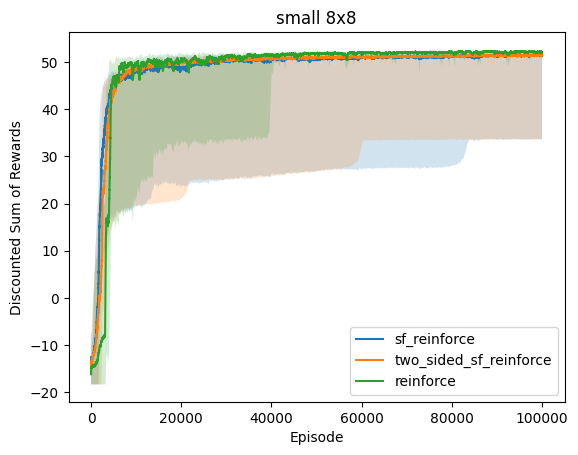

sf_reinforce medium
10 150000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
8,"[-0.09, -0.25, -0.26, -0.38, 1.2, -0.98]","[0.44, -0.45, 0.42, -0.71, 1.03, 1.06]","[-0.79, 0.07, 0.44, 1.14, 0.92, -0.7]","[-1.31, -0.67, -0.51, 0.57, 0.34, -0.27]",0.32,0.15,0.51,-0.34,78.228966
1,"[0.06, -0.08, -0.09, -0.94, -0.06, -0.23]","[-0.15, 1.4, 0.15, -0.37, 0.56, 0.0]","[0.67, -0.65, -0.36, 1.1, -0.48, 0.53]","[0.02, -0.24, 0.08, -0.59, -0.11, -0.22]",0.25,0.74,-0.01,-0.29,78.181710
4,"[-1.08, -0.28, -1.1, -0.01, -0.96, -0.01]","[0.34, 0.81, 0.53, 0.43, -0.13, -0.63]","[1.66, -1.42, -0.27, 1.15, 0.33, 0.44]","[-0.94, -0.18, -0.28, -1.38, 0.35, -0.09]",0.04,-0.35,0.01,0.13,77.703848
0,"[-0.65, 0.17, -0.05, -0.42, -0.39, -0.59]","[1.45, 1.0, -0.66, -0.82, -0.24, 0.5]","[0.37, -0.61, -0.07, 1.03, 0.27, 0.51]","[0.0, 0.0, -0.81, -0.18, -0.33, 0.31]",-0.61,0.25,-0.89,0.03,77.651079
9,"[0.01, -0.73, -0.21, 0.39, 0.1, -0.25]","[0.25, 0.71, -0.19, -0.08, 0.29, 0.53]","[0.09, -0.02, -0.04, 1.27, 0.52, -0.0]","[-0.82, 0.22, -0.38, 0.13, 0.37, -0.35]",0.33,-0.41,0.52,-0.15,77.568669
5,"[-0.25, -0.7, 0.96, 0.48, 0.61, 0.14]","[-0.29, 1.49, -1.15, 0.14, -0.24, -0.44]","[-0.54, -0.46, 0.28, 0.84, 1.03, 0.41]","[-0.28, -0.19, -0.43, -0.44, 0.35, -0.8]",0.23,-0.97,0.19,0.41,76.941912
6,"[-0.58, 0.22, 0.93, 0.27, -0.15, -0.75]","[-0.17, -0.0, -0.48, -0.93, 0.18, 0.92]","[0.02, -0.56, -0.81, 0.33, 0.89, 0.4]","[-0.94, -0.26, -0.42, 0.34, -0.06, -0.46]",0.00,-0.37,0.30,0.46,76.778277
3,"[-0.83, -0.11, -0.22, 0.02, -0.34, -0.72]","[0.55, 0.66, 0.41, -0.37, 0.09, 1.02]","[0.02, -0.17, 0.59, 1.06, -0.0, 0.53]","[0.01, 0.18, 0.2, 0.8, 0.85, -0.01]",0.42,-0.27,-0.88,-0.29,75.434856
2,"[0.15, -0.05, -0.02, -0.1, 0.34, -0.08]","[-0.1, -0.41, 0.16, -0.31, -0.07, 0.19]","[-0.09, 0.45, 0.28, -0.05, 0.3, 0.24]","[-0.16, 0.22, -0.2, 0.09, -0.1, 0.03]",0.02,0.06,0.13,-0.25,-10.118193
7,"[0.12, -0.3, 0.17, 0.09, -0.3, -0.2]","[-0.25, 0.11, -0.06, 0.38, 0.36, 0.26]","[-0.18, -0.12, 0.02, -0.06, 0.14, -0.32]","[0.4, -0.41, 0.19, -0.02, 0.31, -0.09]",-0.10,0.12,0.38,0.06,-10.340505


two_sided_sf_reinforce medium
10 150000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
0,"[-0.06, 0.17, -0.34, -0.34, -0.15, -0.07]","[0.01, 0.84, -0.07, -0.4, -0.13, 0.18]","[-0.32, -0.6, -0.11, 0.69, 0.18, 0.48]","[-0.25, -0.33, 0.19, 0.16, -0.13, 0.06]",-0.09,0.03,0.49,-0.46,78.203868
1,"[0.17, -0.31, -0.12, -0.02, -0.43, -0.1]","[-0.09, 0.68, 0.05, -0.56, 0.11, 0.27]","[0.2, -0.45, 0.07, 0.66, 0.11, 0.17]","[0.39, 0.14, -0.18, -0.24, -0.12, -0.25]",-0.23,0.07,0.38,0.10,78.097710
4,"[0.06, 0.06, -0.33, -0.27, -0.39, -0.47]","[0.44, 0.8, 0.04, -0.26, -0.17, -0.07]","[0.37, -0.44, 0.19, 0.94, 0.23, -0.05]","[-0.12, -0.43, 0.01, -0.18, 0.05, -0.29]",0.29,0.08,0.34,0.05,78.017864
3,"[-0.39, -0.29, -0.13, -0.47, -0.03, -0.38]","[0.27, 0.77, 0.03, -0.39, -0.08, 0.13]","[-0.31, -0.73, -0.26, 0.7, -0.22, 0.52]","[0.31, 0.29, 0.04, -0.28, 0.31, -0.45]",-0.34,-0.25,0.06,0.01,77.970526
2,"[0.08, -0.14, 0.06, -0.16, 0.15, -0.04]","[0.01, 0.13, 0.12, -0.61, 0.1, 0.64]","[-0.11, 0.01, 0.08, 0.85, 0.19, -0.38]","[-0.19, 0.21, -0.46, -0.25, -0.03, -0.11]",-0.13,0.22,0.04,-0.30,77.846801
8,"[0.05, 0.09, 0.3, -0.39, -0.06, -0.2]","[0.36, 0.01, 0.09, -0.58, 0.35, 0.56]","[-0.24, -0.54, -0.34, 0.94, 0.28, -0.11]","[-0.06, -0.33, -0.37, -0.09, -0.36, -0.06]",0.10,-0.25,0.03,-0.14,77.717792
5,"[0.29, -0.32, 0.32, 0.23, 0.3, -0.4]","[-0.23, 0.87, -0.43, -0.33, 0.11, 0.21]","[-0.34, -0.46, 0.29, 0.76, 0.44, 0.32]","[-0.35, 0.2, 0.11, -0.18, -0.36, -0.1]",0.28,-0.31,0.25,0.04,77.681053
6,"[0.03, 0.01, 0.33, -0.02, -0.25, -0.18]","[0.2, 0.68, 0.07, -0.57, -0.07, 0.49]","[0.15, -0.18, -0.13, 0.81, 0.35, 0.09]","[-0.14, -0.25, -0.38, -0.28, -0.15, 0.01]",-0.02,-0.01,-0.06,0.16,77.661875
9,"[0.1, -0.21, -0.05, 0.06, 0.33, -0.02]","[-0.17, 0.45, -0.06, 0.13, 0.37, 0.43]","[-0.29, -0.22, 0.05, 0.19, 0.03, -0.01]","[-0.04, 0.07, 0.09, 0.03, 0.32, 0.08]",-0.08,-0.31,0.41,0.18,-8.938860
7,"[0.02, -0.25, 0.1, 0.09, -0.21, -0.13]","[-0.2, 0.14, -0.07, 0.36, 0.31, 0.29]","[-0.18, -0.23, -0.04, -0.1, 0.19, -0.29]","[0.36, -0.32, 0.28, -0.13, 0.19, -0.02]",0.00,0.09,0.35,0.09,-10.406363


reinforce medium
10 150000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
7,"[-6.45, -6.68, -0.16, -0.11, -0.59, -0.52]","[-0.2, 0.16, -0.22, 0.16, 0.22, 0.06]","[0.11, -0.0, 0.38, 0.25, 0.61, 0.02]","[-0.09, -0.76, -0.02, -0.39, -0.26, -0.32]",-0.42,-0.06,1.06,-0.49,78.908829
5,"[-2.06, -2.63, 0.01, -0.14, 0.09, -0.57]","[-0.19, 0.37, -0.46, 0.24, -0.04, 0.14]","[-0.28, 0.11, 0.37, 0.29, 0.61, 0.2]","[-6.67, -5.98, -0.51, -0.87, -0.88, -0.61]",-0.37,-0.32,0.51,-0.65,78.825448
6,"[-0.28, -0.27, 0.04, -0.14, -0.6, -0.33]","[0.28, 0.31, 0.26, -0.12, 0.03, 0.12]","[0.08, 0.2, -0.27, 0.2, 0.4, 0.06]","[-0.68, -0.72, -0.93, -0.81, -0.6, -0.26]",-0.55,0.33,-0.13,-0.45,78.810152
3,"[-8.49, -8.4, -0.35, -0.63, -0.14, -0.49]","[0.21, 0.22, -0.15, 0.07, -0.17, 0.22]","[-0.27, -0.1, -0.14, 0.2, -0.11, 0.39]","[-7.1, -7.08, -0.21, -0.59, 0.05, -0.79]",-0.72,-0.34,0.23,-0.63,78.708376
4,"[-5.83, -5.88, -0.67, -0.63, -0.73, -0.84]","[0.37, 0.35, -0.0, 0.28, -0.19, -0.28]","[0.44, 0.01, 0.2, 0.36, 0.37, -0.13]","[-0.65, -0.87, -0.42, -0.58, -0.34, -0.5]",-0.11,-0.00,0.55,-0.32,78.696109
1,"[-3.35, -3.75, -0.49, -0.27, -0.8, -0.4]","[-0.06, 0.29, 0.12, -0.03, 0.05, 0.08]","[0.33, -0.05, 0.09, 0.11, 0.3, 0.17]","[-7.21, -7.46, -0.67, -0.8, -0.58, -0.76]",-0.89,0.09,0.58,-0.11,78.687148
2,"[-0.51, -0.65, -0.16, -0.31, 0.02, -0.28]","[0.2, -0.02, 0.29, -0.17, 0.18, 0.29]","[-0.06, 0.34, 0.06, 0.23, 0.21, -0.22]","[-5.26, -4.73, -1.12, -0.79, -0.59, -0.46]",-0.61,0.45,0.06,-0.56,78.658592
8,"[-1.19, -0.99, -0.12, -0.59, -0.47, -0.4]","[0.45, -0.3, 0.24, -0.16, 0.53, 0.28]","[-0.18, -0.19, -0.37, 0.39, 0.27, -0.15]","[-2.3, -2.54, -0.79, -0.51, -0.8, -0.41]",-0.48,-0.08,0.19,-0.61,78.392582
9,"[-0.44, -0.72, -0.13, 0.17, -0.07, -0.07]","[-0.06, 0.46, 0.14, 0.07, 0.65, 0.24]","[0.0, 0.11, 0.3, 0.32, 0.19, 0.23]","[-0.07, -0.04, -0.61, -0.58, -0.05, 0.06]",-0.65,0.04,0.70,-0.40,77.096466
0,"[-7.68, -7.51, -0.5, -0.52, -0.31, -0.38]","[0.02, 0.38, -0.06, 0.04, -0.1, -0.06]","[-0.28, -0.17, 0.0, 0.23, 0.31, 0.36]","[-0.86, -0.72, -0.27, -0.06, -0.61, -0.18]",-0.64,0.04,0.77,-0.85,62.207477


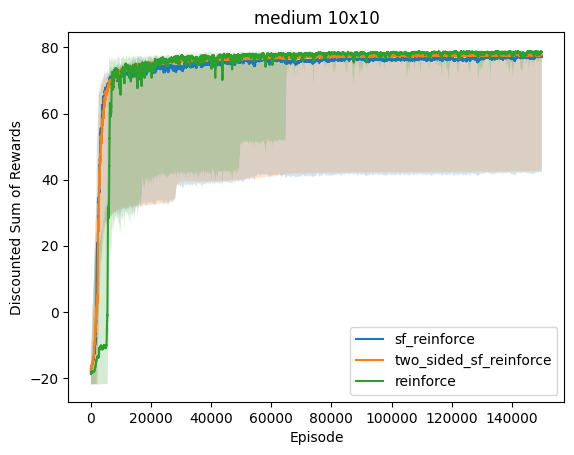

sf_reinforce medium20
10 150000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
1,"[2.77, -1.67, 3.11, 0.49, -1.29, -0.97]","[-1.23, 1.21, -1.64, -0.53, 0.33, -0.54]","[1.6, -2.27, 3.03, 2.23, 0.7, -0.39]","[1.05, -0.37, -1.47, -0.96, -1.41, -1.65]",-0.76,1.93,0.08,0.86,254.464634
8,"[1.2, 1.52, -1.57, -2.17, 1.48, -0.1]","[-0.39, -1.01, 0.97, -1.07, 0.04, 3.16]","[1.8, -1.07, -1.29, 1.73, -0.79, 0.66]","[0.47, 0.12, -0.54, -1.0, 1.81, -1.66]",-0.14,-2.63,0.78,-1.86,252.036273
4,"[-3.7, 0.64, -3.48, -0.1, -0.16, -1.35]","[-0.27, 0.43, -0.16, 0.2, -0.64, -0.27]","[-1.78, -1.74, 2.77, 3.05, 1.31, -1.05]","[-1.39, -1.1, -0.69, -1.39, 0.97, -1.18]",-0.10,-3.75,1.23,1.30,250.574564
2,"[0.27, -0.74, -0.02, -0.01, 0.3, -1.36]","[-0.28, -0.46, -0.33, -0.72, 0.59, 1.08]","[0.78, -0.49, 0.33, 2.55, -0.84, -1.76]","[-0.4, -1.16, -1.37, 0.36, 0.71, -0.32]",0.02,0.22,-0.47,-1.34,250.132265
9,"[0.9, 0.3, 0.24, 0.53, 2.16, 0.96]","[0.45, 3.68, -2.18, -0.57, 1.11, 0.33]","[2.05, -1.08, -1.55, 2.22, 0.4, 1.83]","[-1.56, -0.33, -0.4, -0.62, 3.52, -1.14]",-1.21,0.01,-0.44,0.45,246.657238
6,"[1.76, -1.94, 0.6, 1.5, 0.92, -2.39]","[-0.72, 1.17, -0.29, -0.87, -0.25, 2.98]","[-3.04, -1.48, -0.58, 3.91, 0.29, 1.3]","[-0.72, 0.76, 0.11, -0.84, -1.51, 0.87]",1.57,-0.82,-0.04,1.13,244.216386
5,"[-0.07, -1.09, 2.07, -1.03, -0.43, -0.67]","[-1.34, 1.74, 1.55, -0.44, 0.78, 1.26]","[-0.3, -1.27, 0.78, 4.23, 0.75, -0.05]","[-0.58, -1.71, 0.34, -0.31, -1.86, -1.51]",1.48,-1.88,-0.42,-1.78,242.989315
0,"[0.59, -2.47, 2.06, -2.24, 0.48, -0.69]","[-0.09, 1.35, -2.14, 1.82, -0.13, 0.53]","[-0.16, -0.14, -1.45, 2.78, 2.51, 0.93]","[-0.13, 1.22, 0.89, 1.84, -1.02, -0.77]",-2.13,-0.55,0.49,-0.34,238.990741
3,"[-2.25, -0.69, 2.24, -1.68, -2.22, -1.29]","[-1.85, 1.34, 1.07, 1.4, 1.29, -1.09]","[-3.1, -1.86, -0.39, 2.2, -0.93, 1.2]","[0.31, -1.6, 0.24, 1.14, 3.16, 0.31]",1.42,0.82,1.38,-2.71,238.113304
7,"[0.11, -0.28, -0.06, 0.32, -0.11, -0.14]","[-0.2, 0.18, -0.06, 0.48, 0.38, 0.22]","[-0.33, -0.43, 0.07, 0.1, 0.17, -0.25]","[0.34, -0.43, 0.36, -0.24, 0.23, -0.0]",-0.02,-0.03,0.44,0.13,-15.775366


two_sided_sf_reinforce medium20
10 150000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
0,"[-0.08, 0.05, -0.34, -0.44, -0.22, -0.02]","[0.05, 1.32, -0.09, -1.15, -0.05, 0.39]","[-0.32, -1.07, -0.12, 1.36, 0.19, 0.3]","[-0.35, -0.26, 0.16, 0.12, -0.2, 0.01]",-0.25,0.17,0.48,-0.52,255.653197
3,"[-0.34, -0.27, -0.11, -0.47, -0.11, -0.31]","[0.05, 1.24, -0.07, -0.98, -0.1, 0.36]","[-0.04, -1.22, -0.15, 1.47, -0.06, 0.38]","[0.36, 0.37, 0.09, -0.22, 0.32, -0.53]",-0.41,-0.32,0.14,-0.24,254.426168
4,"[0.13, 0.09, -0.48, -0.25, -0.48, -0.42]","[0.38, 1.29, 0.12, -0.85, -0.26, 0.06]","[0.44, -0.97, 0.2, 1.67, 0.37, -0.18]","[-0.11, -0.45, -0.11, -0.09, 0.08, -0.36]",0.20,0.18,0.48,-0.07,254.071195
5,"[0.2, -0.27, 0.41, 0.27, 0.41, -0.29]","[-0.41, 1.66, -0.4, -0.79, -0.01, 0.19]","[-0.18, -1.05, 0.28, 1.46, 0.54, 0.54]","[-0.32, 0.28, 0.09, -0.12, -0.57, 0.01]",-0.02,-0.20,0.34,-0.14,253.963508
1,"[0.27, -0.26, -0.11, 0.01, -0.42, -0.07]","[0.03, 1.21, 0.15, -1.32, 0.12, 0.42]","[0.06, -0.92, 0.01, 1.28, 0.15, 0.02]","[0.27, 0.12, -0.33, -0.25, -0.1, -0.19]",-0.20,0.07,0.63,0.05,253.860294
6,"[0.04, -0.01, 0.31, -0.03, -0.18, -0.17]","[0.07, 1.04, 0.07, -1.19, -0.15, 0.54]","[0.08, -0.76, 0.03, 1.44, 0.42, -0.18]","[-0.11, -0.18, -0.22, -0.29, -0.13, -0.12]",-0.17,-0.00,0.15,0.06,253.229183
8,"[0.05, 0.01, 0.32, -0.39, -0.04, -0.27]","[0.25, 0.47, 0.09, -1.17, 0.45, 0.63]","[-0.12, -1.07, -0.28, 1.59, 0.3, -0.41]","[-0.06, -0.34, -0.24, -0.21, -0.39, -0.07]",-0.06,-0.25,0.35,-0.19,253.214758
7,"[0.03, -0.24, 0.12, 0.08, -0.22, -0.09]","[-0.23, 0.12, -0.09, 0.38, 0.31, 0.26]","[-0.18, -0.24, -0.04, -0.11, 0.19, -0.34]","[0.37, -0.33, 0.28, -0.12, 0.2, -0.04]",-0.01,0.10,0.34,0.07,-15.745804
2,"[0.09, -0.1, 0.11, -0.01, 0.17, 0.04]","[-0.05, -0.33, 0.1, -0.35, 0.06, 0.05]","[-0.09, 0.34, 0.03, 0.17, 0.17, -0.24]","[-0.16, 0.4, -0.41, -0.05, -0.03, 0.32]",-0.05,0.12,-0.01,-0.24,-27.901779
9,"[0.11, -0.18, -0.01, 0.24, 0.34, 0.13]","[-0.19, 0.37, -0.09, -0.06, 0.38, 0.09]","[-0.29, -0.24, 0.02, -0.0, 0.02, -0.12]","[-0.03, 0.12, 0.13, 0.22, 0.33, 0.37]",-0.06,-0.33,0.35,0.21,-27.995514


reinforce medium20
10 150000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
8,"[-7.79, -7.54, -0.04, -0.54, -0.43, -0.32]","[0.45, -0.26, 0.2, -0.18, 0.42, 0.28]","[-0.21, -0.26, -0.34, 0.4, 0.37, -0.16]","[-5.47, -5.66, -1.0, -0.8, -0.94, -0.71]",-0.47,-0.05,0.11,-0.51,255.941413
4,"[-6.89, -6.88, -0.63, -0.56, -0.7, -0.71]","[0.47, 0.37, 0.12, 0.24, -0.04, -0.17]","[0.45, 0.08, 0.2, 0.46, 0.3, -0.13]","[-2.57, -2.78, -0.44, -0.59, -0.31, -0.43]",0.01,0.21,0.35,-0.32,255.673432
6,"[0.05, 0.05, 0.16, -0.13, -0.29, -0.09]","[0.31, 0.36, 0.52, 0.06, 0.46, 0.21]","[0.17, 0.3, -0.29, 0.24, 0.06, 0.13]","[-5.17, -5.24, -1.03, -0.85, -0.86, -0.28]",-0.26,0.69,-0.44,-0.32,255.230199
1,"[-1.03, -1.4, -0.28, 0.1, -0.56, -0.13]","[-0.05, 0.27, 0.2, -0.02, 0.33, 0.2]","[0.39, 0.04, 0.07, 0.19, 0.01, 0.16]","[0.72, 1.1, -0.52, -0.58, -0.38, -0.51]",-0.54,0.39,0.34,-0.15,214.710550
2,"[-0.38, -0.55, 0.1, -0.1, 0.29, -0.01]","[0.27, 0.05, 0.33, -0.11, 0.18, 0.36]","[0.36, 0.72, -0.04, 0.18, -0.02, -0.36]","[-1.0, -0.45, -0.85, -0.54, -0.38, -0.05]",-0.14,0.33,-0.02,-0.62,207.652722
7,"[0.33, 0.04, -0.05, 0.09, -0.37, -0.08]","[-0.07, 0.18, 0.0, 0.18, 0.46, 0.22]","[0.83, 0.83, 0.2, 0.22, 0.32, -0.12]","[0.33, -0.37, -0.03, -0.33, -0.02, 0.07]",-0.41,0.46,0.58,-0.39,193.962108
3,"[-5.43, -5.34, -0.31, -0.54, -0.19, -0.49]","[0.2, 0.22, -0.17, 0.03, -0.23, 0.22]","[-0.26, -0.1, -0.13, 0.24, -0.05, 0.39]","[-5.92, -5.9, -0.17, -0.54, 0.03, -0.69]",-0.51,-0.40,0.18,-0.48,124.151795
0,"[0.96, 0.4, -0.52, -0.43, -0.38, -0.03]","[0.23, 0.45, 0.08, 0.26, -0.06, -0.04]","[-0.17, -0.04, 0.04, 0.16, 0.42, 0.47]","[-0.25, -0.1, -0.04, 0.17, -0.2, 0.29]",-0.35,0.11,0.74,-0.63,-15.483670
5,"[2.49, 1.87, 0.11, 0.18, 0.12, -0.43]","[-0.13, 0.23, 0.21, 0.71, 0.57, 0.24]","[-0.24, 0.26, 0.01, -0.01, 0.34, 0.22]","[-0.37, 0.51, -0.15, -0.36, -0.51, 0.21]",-0.13,0.38,0.30,-0.36,-15.523105
9,"[-0.03, -0.31, 0.07, 0.25, 0.33, 0.2]","[-0.09, 0.46, -0.03, -0.01, 0.48, 0.16]","[0.81, 0.81, -0.13, -0.14, -0.04, 0.1]","[0.1, 0.29, 0.16, 0.31, 0.38, 0.33]",-0.14,-0.28,0.41,0.25,-27.389302


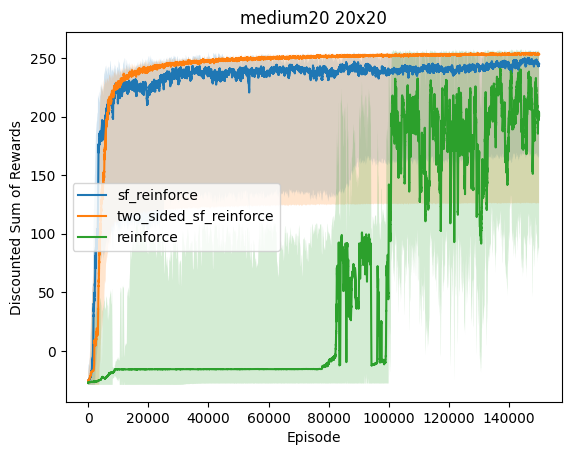

sf_reinforce large
10 200000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
4,"[7.98, 0.16, -5.81, -1.18, -0.53, -6.22]","[2.23, 8.34, -0.95, 3.02, -1.01, 0.05]","[0.96, 2.41, -0.06, 12.04, 0.64, -2.9]","[3.79, -7.66, -8.41, 1.85, 4.11, -2.08]",1.45,8.53,13.15,-0.70,829.972781
8,"[-2.37, 4.2, 5.59, 2.54, 5.16, -11.65]","[21.35, 5.62, -3.33, -10.14, -4.94, 6.29]","[3.43, -0.84, 5.49, 5.88, -5.77, -2.21]","[-3.87, -0.12, 4.64, -4.25, -1.47, -6.73]",-4.48,0.07,-6.90,-7.96,813.793470
5,"[0.15, 2.71, 1.61, -0.12, -2.78, -0.75]","[-8.34, 9.83, 1.05, -0.26, 2.79, -0.27]","[-9.92, 2.03, 0.43, 2.25, -2.01, 4.82]","[-4.8, -2.03, -0.83, 4.37, 3.56, 0.47]",-2.61,-7.16,-1.62,-2.09,782.946760
0,"[-0.2, 4.37, 3.01, -14.11, -0.94, -5.25]","[-3.17, 9.82, 4.81, -6.6, 1.39, 2.46]","[-6.93, -1.58, 3.21, 6.7, -4.64, 0.24]","[-5.64, 6.43, 1.37, -4.51, 3.65, -5.12]",-8.30,-3.25,5.72,-0.97,765.317882
3,"[2.47, -3.75, 3.23, -4.58, -7.43, -8.78]","[1.66, 1.64, -2.23, -5.08, -0.68, 4.43]","[1.21, -3.26, -6.75, 3.93, -0.41, 0.92]","[-3.0, 6.3, -3.76, -3.43, -7.15, -6.41]",3.45,3.93,7.71,7.12,688.703120
1,"[-0.04, 0.18, -0.08, -0.3, -0.39, 0.18]","[0.01, 0.49, 0.39, 0.63, 0.04, 0.33]","[-0.04, -0.27, -0.16, 0.23, 0.35, 0.02]","[0.37, -0.02, -0.27, -0.64, -0.07, -0.32]",-0.09,0.33,0.30,0.15,-21.046756
2,"[0.08, -0.29, 0.32, 0.24, 0.23, 0.07]","[-0.24, -0.39, -0.14, -0.48, -0.2, -0.19]","[-0.09, 0.63, 0.19, 0.31, 0.3, 0.39]","[-0.22, 0.33, -0.45, -0.01, 0.04, 0.06]",0.09,-0.25,-0.04,-0.25,-21.157432
7,"[0.11, -0.45, 0.39, -0.15, -0.35, -0.1]","[-0.31, 0.19, -0.45, 0.36, 0.21, 0.16]","[-0.38, -0.39, -0.23, -0.09, 0.12, -0.28]","[0.15, -0.65, 0.35, -0.09, 0.11, -0.06]",-0.22,0.09,0.20,-0.08,-21.245707
6,"[0.17, 0.03, 0.39, 0.14, -0.44, 0.12]","[0.05, 0.01, 0.11, -0.24, -0.21, 0.02]","[0.31, 0.12, -0.36, 0.41, 0.13, 0.4]","[-0.11, -0.07, -0.33, -0.36, -0.1, 0.02]",0.16,-0.09,-0.17,0.51,-21.266969
9,"[0.11, -0.13, 0.39, 0.56, 0.22, 0.65]","[-0.12, 1.08, -0.35, 0.02, 0.18, -0.2]","[-0.25, -0.28, -0.43, -0.09, -0.01, 0.18]","[-0.17, -0.29, -0.45, 0.2, 0.11, 0.11]",-0.36,0.03,0.08,0.07,-33.095503


two_sided_sf_reinforce large
10 200000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
1,"[0.22, -0.52, -0.22, 0.12, -0.24, -0.19]","[-0.77, 2.36, 0.4, -2.91, -0.07, 0.99]","[0.19, -2.08, 0.21, 2.85, 0.39, -0.28]","[0.05, 0.36, -0.53, -0.3, -0.28, -0.47]",-0.22,0.89,0.68,-0.42,825.151499
4,"[0.11, -0.05, -0.28, -0.34, -0.44, -0.87]","[0.62, 2.3, 0.14, -2.53, -0.38, 0.75]","[0.1, -1.85, 0.2, 3.57, 0.43, -1.1]","[-0.61, -0.56, 0.01, -0.24, -0.01, -0.5]",0.03,0.65,0.60,-0.62,822.445648
0,"[-0.13, 0.07, -0.21, -0.7, 0.15, -0.59]","[-0.43, 2.34, -0.28, -2.56, 0.13, 0.99]","[0.04, -1.85, -0.97, 3.15, 0.53, -0.46]","[-0.11, -0.15, 0.46, 0.38, -0.44, -0.59]",-0.40,0.00,0.80,-0.60,821.555882
3,"[-0.61, -0.53, -0.27, -0.59, -0.36, -1.05]","[0.86, 2.48, -0.17, -2.87, -0.08, 0.91]","[-0.14, -2.28, 0.35, 2.98, -0.19, -0.11]","[0.54, 0.35, 0.06, -0.17, 0.49, -0.38]",-0.88,0.11,0.58,-0.52,820.561051
8,"[0.01, 0.22, -0.29, -0.64, -0.23, -0.28]","[-0.1, 1.9, -0.11, -2.83, 0.62, 1.18]","[-0.18, -2.29, -0.13, 2.97, 0.57, -0.36]","[-0.28, -0.13, -0.45, -0.44, -0.32, -0.09]",-0.42,-0.14,0.44,-0.88,819.985583
5,"[-0.1, -0.44, 0.05, 0.36, 0.47, -0.26]","[-0.04, 2.65, -0.91, -2.36, -0.52, 0.38]","[-0.01, -2.11, 0.3, 3.19, 0.63, -0.37]","[-0.11, 0.01, 0.16, -0.25, -0.86, -0.2]",0.04,0.28,0.65,-0.33,818.203428
6,"[-0.01, 0.13, 0.4, -0.12, -0.47, -0.22]","[0.15, 1.49, 0.19, -1.81, -0.33, 0.61]","[0.05, -1.1, -0.33, 1.66, 0.28, -0.21]","[-0.22, -0.27, -0.25, -0.25, -0.25, -0.23]",-0.11,-0.04,0.03,0.02,788.507939
7,"[0.03, -0.24, 0.12, 0.07, -0.22, -0.08]","[-0.23, 0.13, -0.07, 0.38, 0.3, 0.25]","[-0.17, -0.24, -0.04, -0.11, 0.19, -0.35]","[0.38, -0.32, 0.29, -0.11, 0.2, -0.05]",0.00,0.10,0.33,0.08,-21.161699
2,"[0.09, -0.1, 0.11, -0.02, 0.17, 0.08]","[-0.05, -0.33, 0.1, -0.36, 0.05, 0.03]","[-0.09, 0.33, 0.03, 0.17, 0.17, -0.24]","[-0.16, 0.39, -0.4, -0.04, -0.03, 0.3]",-0.04,0.11,-0.02,-0.23,-33.149805
9,"[0.12, -0.17, -0.01, 0.24, 0.34, 0.18]","[-0.2, 0.37, -0.09, -0.07, 0.37, 0.06]","[-0.3, -0.24, 0.01, -0.01, 0.02, -0.12]","[-0.04, 0.11, 0.15, 0.24, 0.33, 0.35]",-0.05,-0.34,0.35,0.22,-33.157390


reinforce large
10 200000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
0,"[0.31, 0.29, -0.25, -0.11, -0.15, 0.33]","[1.97, 1.32, -0.23, -0.03, -0.3, -0.21]","[-0.02, 0.07, 0.06, 0.18, 0.5, 0.61]","[-0.3, -0.11, 0.12, 0.37, -0.27, 0.27]",-0.18,-0.04,0.68,-0.55,2.409756
3,"[-0.4, -0.32, -0.29, -0.4, -0.11, -0.47]","[0.21, 0.14, 0.09, 0.34, 0.03, 0.25]","[-0.28, -0.03, -0.2, -0.01, 0.02, 0.38]","[0.28, 0.31, -0.17, -0.35, 0.03, -0.69]",-0.39,-0.21,0.30,-0.39,-14.312385
8,"[-0.03, 0.18, -0.06, -0.43, -0.43, -0.28]","[0.51, -0.23, 0.23, -0.15, 0.5, 0.33]","[-0.26, -0.34, -0.42, 0.3, 0.39, -0.22]","[-0.1, -0.33, -0.47, -0.17, -0.42, -0.16]",-0.27,-0.03,0.28,-0.63,-16.765111
7,"[0.65, 0.35, -0.06, 0.01, -0.27, 0.14]","[-0.1, 0.11, 0.5, 0.7, 0.78, 0.21]","[5.17, 4.35, -0.03, 0.03, 0.15, -0.3]","[0.44, -0.07, -0.13, -0.32, -0.1, 0.2]",-0.19,1.01,-0.27,-0.26,-20.975033
6,"[2.21, 0.85, 0.11, -0.02, -0.46, -0.19]","[1.15, 0.72, 0.14, -0.2, 0.07, -0.0]","[0.37, 0.49, -0.08, 0.34, 0.57, 0.33]","[-0.08, -0.02, -0.55, -0.37, -0.44, 0.3]",-0.52,0.19,0.35,-0.38,-20.988086
9,"[0.66, 0.38, -0.04, 0.24, 0.25, 0.28]","[1.34, 1.92, -0.04, 0.0, 0.5, 0.31]","[6.89, 6.92, 0.39, 0.35, 0.29, 0.18]","[2.12, 2.27, -0.12, 0.13, 0.16, 0.26]",-0.18,-0.36,0.79,-0.09,-21.000904
4,"[3.8, 3.33, -0.3, -0.08, -0.45, -0.19]","[0.62, 0.5, 0.3, 0.49, 0.2, 0.03]","[3.81, 3.42, 0.2, 0.38, 0.22, -0.26]","[-0.12, -0.22, -0.58, -0.66, -0.31, 0.02]",0.09,0.53,0.22,-0.29,-21.001274
5,"[5.36, 3.83, 0.17, 0.23, -0.01, -0.5]","[-0.06, 0.28, 0.17, 0.69, 0.73, 0.34]","[-0.12, 0.4, 0.08, -0.03, 0.46, 0.3]","[-0.27, 0.58, -0.27, -0.41, -0.67, 0.3]",-0.01,0.55,-0.03,-0.30,-21.045694
1,"[0.74, 0.33, -0.32, 0.03, -0.4, 0.32]","[1.22, 1.64, 0.39, 0.18, 0.51, 0.28]","[3.85, 3.46, -0.01, 0.03, -0.03, 0.11]","[6.55, 6.29, -0.34, -0.24, -0.38, -0.19]",-0.40,0.51,0.34,-0.19,-21.061271
2,"[1.72, 1.4, 0.15, 0.08, 0.18, 0.03]","[3.02, 1.5, -0.17, -0.58, -0.08, -0.15]","[1.49, 1.9, 0.14, 0.24, 0.22, -0.15]","[-0.91, 0.23, -0.31, 0.03, 0.11, 0.44]",-0.17,0.22,0.05,-0.23,-33.182503


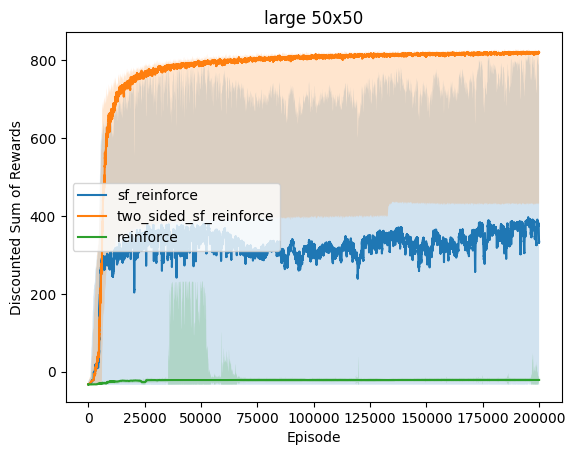

In [6]:
gridsizes = ["4x4", "8x8", "10x10", "20x20", "50x50"]
for grid, gridsize in zip("tiny small medium medium20 large".split(), gridsizes):
    for algo in "sf_reinforce two_sided_sf_reinforce reinforce".split():
        dirname = os.path.join("saves", algo, grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        print(algo, grid)
        avg_rewards, bot, top = get_results(path)
        plt.plot(avg_rewards, label=algo)
        plt.fill_between(range(len(avg_rewards)), bot, top, alpha=0.2)
    plt.title(f"{grid} {gridsize}")
    plt.xlabel('Episode')
    plt.ylabel('Discounted Sum of Rewards')
    plt.legend()
    plt.show()


sf_reinforce_0.101 medium
10 150000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
9,"[-0.04, -0.4, -0.1, -0.16, 0.31, -0.25]","[-0.12, 1.37, -0.19, -1.05, 0.39, 0.82]","[-0.37, -0.8, 0.26, 1.58, 0.02, 0.42]","[-0.07, -0.13, 0.11, -0.08, 0.26, -0.39]",-0.12,-0.25,0.43,0.17,69.713694
1,"[0.11, -0.38, -0.1, -0.28, -0.48, -0.45]","[-0.02, 1.29, -0.08, -1.19, 0.08, 0.83]","[0.22, -0.84, 0.1, 1.61, 0.06, 0.24]","[0.26, -0.15, -0.14, -0.45, -0.19, -0.44]",-0.17,0.11,0.37,0.09,69.347124
0,"[-0.06, 0.01, -0.38, -0.36, -0.2, -0.35]","[0.03, 1.58, -0.08, -1.12, -0.08, 0.69]","[-0.48, -0.96, -0.05, 1.51, 0.15, 0.63]","[-0.39, -0.35, 0.08, 0.06, -0.18, -0.36]",-0.14,0.10,0.39,-0.47,69.344001
4,"[0.1, -0.14, -0.22, -0.25, -0.41, -0.8]","[0.45, 1.29, 0.01, -0.92, -0.13, 0.52]","[0.21, -0.77, 0.29, 1.85, 0.13, -0.04]","[-0.19, -0.59, 0.03, -0.23, -0.07, -0.48]",0.34,0.11,0.24,-0.02,69.250390
8,"[0.11, 0.03, 0.26, -0.59, -0.02, -0.57]","[0.31, 0.6, 0.09, -1.14, 0.42, 1.09]","[-0.3, -0.81, -0.22, 1.88, 0.26, -0.06]","[-0.1, -0.46, -0.35, -0.24, -0.43, -0.39]",0.14,-0.27,-0.12,-0.10,68.958326
6,"[-0.01, -0.02, 0.21, -0.14, -0.08, -0.59]","[0.29, 1.37, 0.09, -1.24, -0.12, 0.88]","[0.09, -0.59, -0.07, 1.68, 0.4, 0.14]","[-0.08, -0.43, -0.46, -0.42, -0.12, -0.28]",0.02,-0.01,-0.14,0.17,68.806830
2,"[0.06, -0.22, -0.0, -0.43, 0.09, -0.43]","[0.07, 0.77, 0.02, -1.18, 0.08, 1.21]","[-0.07, -0.3, 0.16, 1.78, 0.21, -0.25]","[-0.21, 0.02, -0.45, -0.45, 0.05, -0.32]",-0.05,0.25,-0.01,-0.22,68.192727
3,"[-0.38, -0.4, -0.31, -0.33, -0.05, -0.47]","[0.38, 1.27, 0.0, -1.13, -0.05, 0.69]","[-0.27, -0.98, -0.26, 1.58, -0.31, 0.4]","[0.14, 0.18, 0.15, -0.42, 0.29, -0.71]",-0.39,-0.19,-0.12,-0.01,67.817704
7,"[0.11, -0.57, 0.05, -0.15, -0.16, -0.62]","[-0.23, 0.95, -0.13, -0.96, 0.19, 0.69]","[-0.19, -0.8, 0.09, 1.53, 0.25, 0.04]","[0.32, -0.43, 0.32, -0.37, 0.09, -0.49]",-0.02,0.13,0.38,0.06,67.207467
5,"[0.28, -0.44, 0.37, 0.19, 0.37, -0.61]","[-0.23, 1.33, -0.45, -0.92, 0.06, 0.86]","[-0.36, -0.61, 0.37, 1.73, 0.51, 0.21]","[-0.37, -0.03, 0.1, -0.39, -0.36, -0.35]",0.24,-0.30,0.28,0.05,67.071043


two_sided_sf_reinforce_0.101 medium
10 150000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
0,"[-0.04, -0.03, -0.36, -0.39, -0.16, -0.36]","[0.05, 1.5, -0.07, -1.03, -0.13, 0.7]","[-0.37, -0.93, -0.0, 1.55, 0.18, 0.57]","[-0.35, -0.45, 0.07, 0.03, -0.09, -0.31]",-0.14,0.06,0.45,-0.46,69.694491
8,"[0.01, -0.02, 0.3, -0.58, -0.02, -0.48]","[0.44, 0.63, 0.09, -1.17, 0.37, 1.08]","[-0.28, -0.78, -0.25, 1.9, 0.29, -0.11]","[-0.07, -0.45, -0.32, -0.3, -0.33, -0.4]",0.14,-0.21,0.01,-0.12,69.036364
1,"[0.14, -0.43, -0.2, -0.2, -0.39, -0.36]","[-0.01, 1.25, 0.0, -1.13, 0.13, 0.81]","[0.15, -0.83, 0.15, 1.63, 0.11, 0.23]","[0.33, -0.05, -0.19, -0.41, -0.06, -0.52]",-0.19,0.09,0.37,0.17,69.005173
6,"[0.02, -0.11, 0.3, -0.24, -0.22, -0.52]","[0.26, 1.29, 0.04, -1.23, -0.09, 0.94]","[0.09, -0.56, -0.06, 1.69, 0.35, 0.12]","[-0.16, -0.37, -0.35, -0.38, -0.14, -0.28]",-0.02,0.01,-0.12,0.14,68.738456
4,"[0.03, -0.06, -0.35, -0.33, -0.41, -0.68]","[0.45, 1.34, 0.03, -0.94, -0.13, 0.49]","[0.34, -0.74, 0.24, 1.84, 0.25, -0.1]","[-0.22, -0.51, -0.06, -0.27, 0.05, -0.55]",0.27,0.14,0.34,0.01,68.288567
9,"[0.09, -0.36, -0.1, -0.1, 0.32, -0.34]","[-0.13, 1.34, -0.14, -1.01, 0.39, 0.85]","[-0.25, -0.73, 0.21, 1.6, 0.08, 0.38]","[-0.13, -0.15, 0.07, -0.09, 0.3, -0.42]",-0.11,-0.30,0.47,0.14,68.052120
5,"[0.24, -0.39, 0.3, 0.08, 0.33, -0.57]","[-0.2, 1.36, -0.47, -0.87, 0.1, 0.78]","[-0.37, -0.69, 0.36, 1.7, 0.45, 0.28]","[-0.45, 0.08, 0.07, -0.34, -0.4, -0.41]",0.27,-0.26,0.11,0.06,67.829511
3,"[-0.4, -0.37, -0.22, -0.41, -0.03, -0.46]","[0.27, 1.29, -0.03, -1.12, -0.02, 0.69]","[-0.3, -0.92, -0.2, 1.59, -0.23, 0.33]","[0.25, 0.14, 0.1, -0.4, 0.36, -0.72]",-0.30,-0.19,-0.02,-0.06,67.721048
2,"[0.1, -0.22, 0.02, -0.4, 0.17, -0.35]","[0.08, 0.74, 0.1, -1.19, 0.09, 1.19]","[-0.13, -0.24, 0.18, 1.75, 0.19, -0.29]","[-0.23, 0.04, -0.47, -0.42, -0.02, -0.4]",-0.09,0.21,0.01,-0.32,67.335743
7,"[-0.0, -0.41, 0.06, -0.17, -0.21, -0.5]","[-0.17, 1.04, -0.17, -0.9, 0.32, 0.71]","[-0.13, -0.77, 0.12, 1.62, 0.22, 0.09]","[0.34, -0.5, 0.24, -0.29, 0.16, -0.48]",-0.06,0.11,0.41,0.02,66.848193


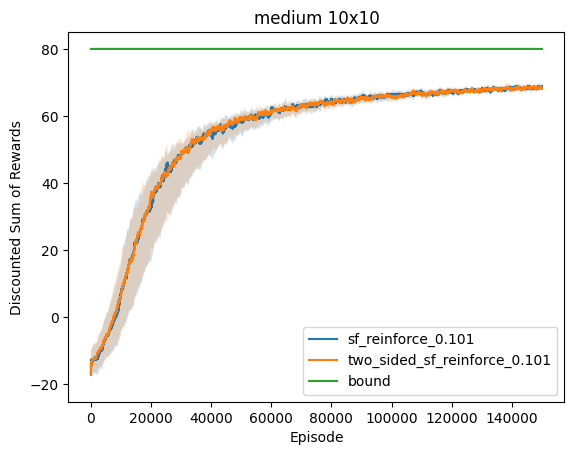

sf_reinforce_0.15 medium
10 150000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
0,"[-0.28, 0.27, -0.32, -0.24, -0.19, -0.15]","[0.11, 1.39, -0.09, -0.91, 0.16, 0.53]","[-0.56, -0.69, -0.15, 1.25, 0.22, 0.46]","[-0.31, -0.41, -0.09, -0.02, -0.15, -0.2]",-0.20,0.30,0.59,-0.19,75.222849
6,"[0.08, 0.13, 0.26, -0.05, -0.23, -0.45]","[0.49, 0.87, 0.19, -1.0, -0.04, 0.71]","[-0.0, -0.57, -0.16, 1.68, 0.4, -0.21]","[-0.28, -0.13, -0.34, -0.34, -0.1, 0.02]",0.16,-0.09,0.10,0.33,74.914315
1,"[0.02, -0.46, -0.09, -0.1, -0.32, -0.22]","[-0.27, 0.91, -0.12, -0.83, 0.1, 0.53]","[-0.06, -0.83, 0.03, 1.36, 0.2, 0.16]","[0.37, -0.01, -0.23, -0.32, -0.35, -0.39]",-0.09,0.05,0.24,0.28,74.814395
3,"[-0.23, -0.05, -0.18, -0.29, -0.05, -0.42]","[0.06, 1.14, -0.01, -1.09, -0.25, 0.66]","[-0.45, -0.76, -0.08, 1.32, -0.24, 0.28]","[0.28, 0.2, 0.04, -0.46, 0.38, -0.71]",-0.40,-0.08,-0.16,0.01,74.571025
2,"[-0.11, -0.12, 0.14, -0.46, 0.24, -0.11]","[-0.07, 0.55, -0.11, -1.18, -0.04, 1.17]","[-0.13, -0.21, 0.15, 1.52, 0.3, -0.38]","[-0.27, 0.21, -0.44, -0.33, -0.03, -0.05]",-0.05,0.44,0.04,-0.16,74.354230
4,"[0.01, 0.0, -0.3, -0.2, -0.44, -0.39]","[0.23, 1.01, 0.01, -0.88, -0.04, 0.3]","[0.34, -0.76, 0.36, 1.33, 0.25, -0.12]","[-0.17, -0.56, -0.23, -0.23, 0.04, -0.42]",0.22,-0.05,0.37,0.22,74.291824
8,"[-0.08, -0.04, 0.18, -0.54, -0.09, -0.39]","[0.26, 0.41, -0.01, -1.11, 0.38, 0.93]","[-0.33, -0.51, -0.13, 1.42, 0.37, -0.25]","[0.03, -0.4, -0.31, -0.1, -0.16, -0.27]",0.13,-0.27,0.22,0.09,73.990402
9,"[-0.05, -0.22, 0.07, -0.11, 0.14, -0.32]","[-0.13, 1.13, -0.24, -0.99, 0.29, 0.59]","[-0.05, -0.49, 0.25, 1.28, 0.11, 0.04]","[0.06, -0.13, 0.05, 0.11, 0.37, -0.3]",-0.06,-0.44,0.33,0.08,73.904269
7,"[0.21, -0.45, -0.05, -0.06, -0.37, -0.33]","[-0.22, 0.71, -0.25, -0.65, 0.22, 0.41]","[-0.16, -0.66, 0.19, 1.34, 0.05, -0.13]","[0.35, -0.48, 0.47, -0.09, 0.16, -0.39]",-0.06,0.18,0.38,0.08,73.638000
5,"[0.2, -0.46, 0.46, 0.17, 0.38, -0.55]","[-0.35, 1.27, -0.37, -0.53, 0.24, 0.65]","[-0.28, -0.56, 0.45, 1.41, 0.32, 0.44]","[-0.4, 0.17, 0.26, -0.23, -0.53, -0.28]",0.38,-0.37,0.11,0.05,72.911639


two_sided_sf_reinforce_0.15 medium
10 150000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
0,"[-0.01, 0.05, -0.36, -0.36, -0.2, -0.18]","[0.04, 1.3, -0.1, -0.88, -0.13, 0.45]","[-0.36, -0.87, -0.02, 1.28, 0.21, 0.46]","[-0.31, -0.38, 0.1, 0.1, -0.1, -0.14]",-0.12,0.08,0.45,-0.41,75.232675
4,"[-0.0, 0.03, -0.33, -0.26, -0.42, -0.52]","[0.49, 1.16, 0.06, -0.79, -0.15, 0.24]","[0.33, -0.69, 0.19, 1.53, 0.24, -0.14]","[-0.17, -0.47, -0.04, -0.2, 0.07, -0.37]",0.22,0.10,0.33,-0.01,75.048561
1,"[0.16, -0.35, -0.11, -0.1, -0.39, -0.22]","[-0.02, 1.05, 0.03, -1.01, 0.13, 0.58]","[0.16, -0.74, 0.07, 1.32, 0.07, 0.13]","[0.36, 0.06, -0.15, -0.31, -0.09, -0.35]",-0.22,0.11,0.37,0.13,74.757758
2,"[0.06, -0.18, 0.04, -0.3, 0.16, -0.2]","[0.05, 0.6, 0.13, -1.1, 0.07, 0.94]","[-0.13, -0.21, 0.13, 1.45, 0.19, -0.38]","[-0.19, 0.08, -0.44, -0.34, -0.04, -0.25]",-0.13,0.22,0.04,-0.31,74.481067
6,"[0.02, -0.03, 0.37, -0.13, -0.27, -0.37]","[0.2, 1.07, 0.05, -1.08, -0.11, 0.7]","[0.09, -0.49, -0.1, 1.37, 0.34, 0.04]","[-0.18, -0.3, -0.33, -0.3, -0.14, -0.15]",-0.03,0.02,-0.10,0.14,74.354148
5,"[0.26, -0.32, 0.29, 0.16, 0.33, -0.43]","[-0.19, 1.19, -0.48, -0.79, 0.08, 0.57]","[-0.37, -0.62, 0.34, 1.39, 0.43, 0.21]","[-0.41, 0.13, 0.08, -0.26, -0.37, -0.23]",0.23,-0.30,0.19,0.06,74.330057
8,"[0.06, 0.02, 0.31, -0.48, 0.02, -0.36]","[0.4, 0.44, 0.07, -1.01, 0.32, 0.83]","[-0.22, -0.75, -0.3, 1.58, 0.25, -0.17]","[-0.06, -0.38, -0.32, -0.18, -0.33, -0.24]",0.11,-0.25,0.05,-0.12,74.261535
9,"[0.08, -0.31, -0.07, 0.0, 0.31, -0.18]","[-0.13, 1.13, -0.13, -0.86, 0.38, 0.61]","[-0.27, -0.66, 0.18, 1.29, 0.06, 0.3]","[-0.09, -0.09, 0.1, -0.02, 0.31, -0.25]",-0.12,-0.32,0.48,0.11,74.118326
3,"[-0.4, -0.34, -0.21, -0.42, -0.03, -0.38]","[0.26, 1.08, -0.03, -0.93, -0.02, 0.47]","[-0.35, -0.93, -0.23, 1.3, -0.24, 0.36]","[0.28, 0.24, 0.08, -0.27, 0.36, -0.55]",-0.34,-0.23,0.02,-0.06,74.018913
7,"[-0.0, -0.33, 0.08, -0.1, -0.25, -0.32]","[-0.21, 0.75, -0.13, -0.63, 0.3, 0.37]","[-0.15, -0.71, 0.08, 1.16, 0.2, 0.08]","[0.33, -0.4, 0.24, -0.22, 0.16, -0.32]",-0.02,0.12,0.44,0.01,72.714998


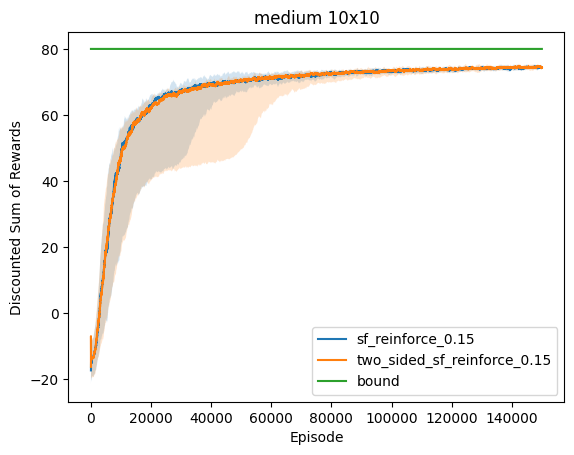

sf_reinforce_0.25 medium
10 150000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
4,"[-0.55, -0.32, -0.14, 0.49, -0.56, -0.57]","[0.91, 0.97, -0.16, -0.95, -0.49, 1.02]","[0.53, -0.15, 0.02, 1.17, 0.93, 0.22]","[0.25, -0.97, -0.19, -1.08, -0.17, 0.41]",0.03,0.29,1.92,-0.10,79.086848
1,"[0.08, 0.23, -0.2, 0.56, -0.73, -1.3]","[0.31, 0.64, -0.32, -0.47, 0.13, 0.46]","[-0.86, -1.0, 0.16, 0.83, 0.16, 0.75]","[0.05, 0.71, -1.04, -0.17, -0.6, -0.25]",-0.95,0.97,0.55,0.73,78.674014
0,"[-0.01, -0.32, -0.46, -0.08, -0.14, -0.34]","[0.16, 1.04, 0.58, -0.56, 0.38, 1.02]","[-0.4, -0.24, 0.64, 0.73, -0.59, 0.96]","[0.0, 0.1, -0.32, -0.09, -0.34, -0.37]",-0.16,-0.10,0.64,-0.88,78.057553
5,"[1.39, -0.57, 0.6, -0.12, 0.5, -0.59]","[-0.46, 0.8, -0.93, -0.0, 0.42, 0.25]","[-0.31, 0.0, 0.54, 1.6, -0.44, -0.59]","[0.43, 0.38, 0.52, -0.01, 0.58, -1.15]",0.37,-0.30,0.58,0.07,77.771330
8,"[0.28, -1.44, 0.21, 0.27, 0.78, -0.67]","[0.08, 0.62, 0.14, -0.34, 0.04, 0.95]","[0.38, 0.33, -0.21, 0.94, 0.47, 0.18]","[-0.79, 0.26, -0.3, -0.75, 0.53, -0.22]",0.04,0.09,-0.44,-1.09,77.415287
6,"[-0.0, -0.08, 0.41, -1.1, -0.15, -1.1]","[0.67, 0.69, 0.06, -0.44, -0.69, 0.48]","[0.95, -0.31, 0.04, 0.63, 0.54, 0.33]","[-0.03, -0.44, -0.32, 0.05, -0.42, 0.06]",0.05,-0.63,0.20,0.47,77.122641
3,"[0.33, -0.18, -0.6, -0.8, -0.72, -1.08]","[-0.53, 0.06, -0.24, -0.1, 0.52, -0.61]","[0.09, -0.92, -0.62, 0.78, -0.01, -0.53]","[0.53, -0.37, -0.59, -0.4, -0.34, -0.77]",-0.38,-0.83,-0.50,-0.93,76.880698
2,"[-0.22, -0.13, 0.06, -0.02, 0.23, -0.07]","[0.19, -0.11, 0.03, -0.37, 0.41, 0.85]","[0.09, 0.61, 0.38, 0.35, 0.14, -0.25]","[-0.32, 0.23, -0.38, -0.25, 0.02, 0.08]",-0.36,0.03,-0.17,-0.36,70.860989
7,"[0.08, -0.29, 0.13, 0.1, -0.24, -0.13]","[-0.26, 0.06, -0.02, 0.43, 0.23, 0.35]","[-0.11, -0.25, -0.01, -0.14, 0.23, -0.33]","[0.39, -0.36, 0.34, -0.06, 0.07, -0.02]",0.04,0.08,0.32,-0.10,-10.311859
9,"[0.37, -0.1, -0.08, 0.18, 0.42, -0.03]","[-0.08, 0.53, -0.03, 0.32, 0.37, 0.61]","[-0.22, -0.19, -0.02, 0.18, 0.05, -0.04]","[-0.25, 0.09, 0.05, 0.13, 0.36, 0.28]",0.17,-0.26,0.25,0.25,-10.381219


two_sided_sf_reinforce_0.25 medium
10 150000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
0,"[-0.02, 0.12, -0.34, -0.31, -0.21, -0.04]","[0.09, 0.86, -0.03, -0.42, -0.1, 0.15]","[-0.39, -0.61, -0.04, 0.68, 0.17, 0.47]","[-0.29, -0.37, 0.11, 0.22, -0.13, 0.06]",-0.12,0.08,0.50,-0.43,78.403322
1,"[0.17, -0.28, -0.13, 0.01, -0.37, -0.1]","[-0.09, 0.65, 0.05, -0.53, 0.14, 0.29]","[0.11, -0.47, 0.06, 0.71, 0.08, 0.18]","[0.37, 0.15, -0.18, -0.25, -0.1, -0.23]",-0.21,0.06,0.36,0.14,78.011698
4,"[0.08, 0.04, -0.3, -0.25, -0.43, -0.45]","[0.41, 0.8, 0.08, -0.25, -0.14, -0.02]","[0.36, -0.41, 0.2, 0.97, 0.25, -0.06]","[-0.19, -0.41, 0.02, -0.21, 0.03, -0.25]",0.22,0.05,0.37,0.03,77.941490
3,"[-0.4, -0.3, -0.16, -0.38, -0.1, -0.38]","[0.22, 0.74, -0.04, -0.38, -0.03, 0.22]","[-0.28, -0.63, -0.24, 0.75, -0.24, 0.47]","[0.27, 0.33, 0.1, -0.28, 0.28, -0.43]",-0.35,-0.23,0.07,-0.07,77.865852
2,"[0.12, -0.11, 0.08, -0.16, 0.11, -0.06]","[0.04, 0.15, 0.13, -0.66, 0.13, 0.67]","[-0.05, 0.05, 0.09, 0.8, 0.22, -0.37]","[-0.2, 0.24, -0.45, -0.19, -0.04, -0.13]",-0.12,0.18,0.02,-0.28,77.750008
8,"[0.07, 0.11, 0.27, -0.41, -0.02, -0.2]","[0.37, -0.02, 0.09, -0.59, 0.4, 0.55]","[-0.26, -0.51, -0.33, 0.96, 0.27, -0.18]","[-0.05, -0.32, -0.34, -0.13, -0.34, -0.07]",0.07,-0.26,0.04,-0.15,77.615901
5,"[0.25, -0.36, 0.34, 0.21, 0.24, -0.33]","[-0.23, 0.91, -0.41, -0.28, 0.08, 0.15]","[-0.34, -0.49, 0.3, 0.78, 0.38, 0.35]","[-0.35, 0.19, 0.1, -0.2, -0.41, -0.11]",0.25,-0.28,0.16,0.09,77.575006
6,"[0.05, 0.05, 0.32, -0.05, -0.22, -0.22]","[0.17, 0.71, 0.05, -0.61, -0.1, 0.44]","[0.07, -0.23, -0.12, 0.78, 0.36, 0.11]","[-0.15, -0.23, -0.34, -0.23, -0.14, -0.02]",-0.03,0.02,-0.06,0.11,77.547300
9,"[0.1, -0.21, -0.05, 0.06, 0.34, -0.04]","[-0.18, 0.37, -0.09, -0.11, 0.37, 0.27]","[-0.28, -0.15, 0.08, 0.45, 0.05, 0.19]","[-0.05, 0.08, 0.1, 0.02, 0.31, 0.08]",-0.10,-0.32,0.38,0.20,70.586268
7,"[0.02, -0.26, 0.13, 0.08, -0.21, -0.13]","[-0.24, 0.14, -0.1, 0.37, 0.29, 0.29]","[-0.17, -0.26, -0.02, -0.1, 0.18, -0.32]","[0.37, -0.34, 0.28, -0.13, 0.18, -0.05]",-0.02,0.11,0.36,0.07,-10.397269


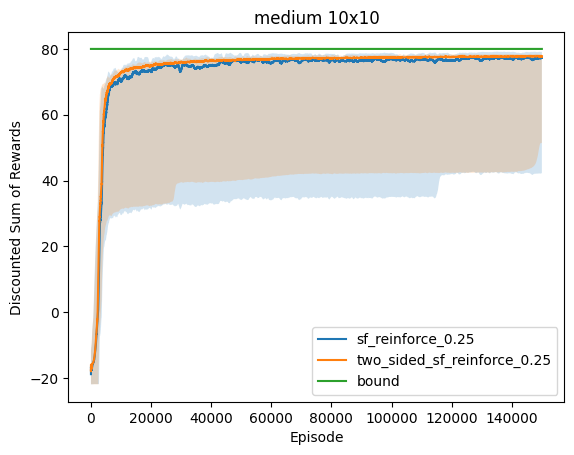

sf_reinforce_0.35 medium
10 150000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
4,"[-0.34, -1.21, -2.16, -0.11, -2.24, 1.39]","[-2.24, 5.2, 0.73, -0.24, 0.31, 0.38]","[-0.28, 1.46, -0.23, 2.22, -1.17, 1.62]","[-1.1, -0.17, 1.81, -0.76, -0.88, -2.56]",1.94,2.10,0.48,1.65,78.167414
5,"[-0.98, -0.07, 1.06, 0.14, 1.02, -0.56]","[-0.53, 2.28, -0.91, -0.71, -3.99, 1.17]","[-1.85, 1.18, 1.47, 1.12, 2.97, 0.43]","[-2.67, 1.81, -0.29, 1.46, -0.11, -1.47]",0.62,0.45,-1.70,-0.20,77.529037
1,"[-1.64, -0.65, -1.71, -0.45, -0.3, 0.66]","[3.07, 0.14, -0.39, 0.19, 1.75, 0.33]","[0.67, -2.0, -1.39, 0.3, 0.18, 2.31]","[-0.0, -2.96, -0.56, -2.01, 0.47, -0.99]",-2.00,0.17,0.98,0.85,77.123947
2,"[0.24, -1.05, -0.54, 0.01, -2.91, -1.13]","[-0.58, 0.42, -1.26, -1.1, -2.02, 2.44]","[1.15, 1.19, 0.98, 1.69, -0.08, -0.45]","[2.36, 0.04, -0.53, 1.13, -1.49, -0.23]",1.19,-2.79,0.73,0.95,76.520086
7,"[0.1, 0.04, 0.94, -1.09, 0.01, -0.67]","[0.81, 0.9, 0.01, -1.26, -0.67, 1.52]","[-0.59, -0.03, 0.43, 1.15, -1.34, 0.2]","[-0.01, 0.47, -0.72, 1.08, 0.28, -0.17]",-0.30,-0.31,1.10,0.32,73.987510
3,"[-0.39, -1.99, -0.0, 0.53, 0.36, -0.17]","[2.19, 0.99, -0.84, 0.8, 0.77, -0.41]","[-0.59, -0.72, -1.4, 1.79, 1.92, 0.59]","[1.29, -0.41, -1.53, 0.17, 1.97, 0.36]",1.30,-0.70,-0.67,-1.14,69.415120
6,"[-0.62, 0.64, 2.84, -2.44, 1.78, -3.56]","[1.18, -2.43, -0.15, -1.41, 1.12, 1.2]","[0.33, -1.73, -1.31, 0.01, 1.41, -0.39]","[-2.3, -1.68, 3.46, -1.19, 1.2, -0.44]",0.59,-1.81,-0.13,1.13,67.820713
0,"[1.66, 1.77, -2.69, 0.65, -0.35, -1.36]","[-2.41, 1.75, -0.96, -0.02, 1.78, 0.77]","[-0.06, 0.28, -1.6, 0.31, 2.04, 1.44]","[1.03, -4.52, -0.96, 1.74, 2.6, 0.01]",-0.26,0.47,-1.00,0.95,66.458243
8,"[3.88, -1.16, 2.62, -1.46, 0.5, -1.39]","[-2.72, 2.13, 0.03, 0.02, 1.13, -0.45]","[0.59, -0.64, 0.05, 2.02, 1.3, -0.7]","[-0.26, -0.23, -1.78, -0.04, -1.48, -2.33]",-0.45,-1.34,0.51,-1.48,64.404513
9,"[1.13, -0.63, 0.03, 0.96, 0.25, -0.09]","[-0.5, -0.11, -0.83, 0.18, 0.86, 0.08]","[-0.46, 0.25, 0.29, -0.27, 0.27, -0.59]","[0.01, 0.35, 1.07, 0.0, 0.4, 0.99]",0.18,-0.22,0.51,-0.02,-20.434371


two_sided_sf_reinforce_0.35 medium
10 150000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
0,"[0.01, 0.14, -0.33, -0.29, -0.15, -0.05]","[0.01, 0.55, 0.02, -0.07, -0.06, 0.04]","[-0.37, -0.34, -0.11, 0.29, 0.23, 0.49]","[-0.3, -0.22, 0.09, 0.21, -0.11, 0.1]",-0.16,0.05,0.53,-0.43,78.683735
1,"[0.2, -0.17, -0.15, -0.0, -0.44, -0.08]","[-0.05, 0.35, 0.08, -0.11, 0.1, 0.11]","[0.16, -0.29, -0.04, 0.31, 0.11, 0.28]","[0.38, 0.11, -0.14, -0.26, -0.08, -0.24]",-0.23,0.13,0.36,0.11,78.335714
3,"[-0.38, -0.26, -0.19, -0.41, 0.04, -0.29]","[0.26, 0.52, -0.02, -0.13, -0.05, 0.12]","[-0.41, -0.32, -0.25, 0.27, -0.24, 0.53]","[0.24, 0.31, 0.07, -0.25, 0.39, -0.49]",-0.35,-0.27,0.16,-0.13,78.267794
4,"[0.02, 0.04, -0.31, -0.27, -0.41, -0.4]","[0.4, 0.58, 0.1, 0.14, -0.14, -0.22]","[0.39, -0.19, 0.13, 0.53, 0.25, 0.06]","[-0.15, -0.42, -0.04, -0.17, 0.05, -0.22]",0.32,0.10,0.39,-0.01,78.158452
2,"[0.08, -0.07, 0.05, -0.09, 0.1, -0.12]","[0.01, -0.09, 0.15, -0.35, 0.06, 0.54]","[-0.07, 0.24, 0.04, 0.33, 0.18, -0.22]","[-0.19, 0.28, -0.46, -0.19, -0.02, -0.03]",-0.11,0.18,0.05,-0.30,78.039881
8,"[0.07, 0.17, 0.29, -0.42, -0.02, -0.2]","[0.36, -0.34, 0.2, -0.25, 0.38, 0.44]","[-0.26, -0.33, -0.35, 0.56, 0.28, -0.07]","[-0.01, -0.3, -0.35, -0.14, -0.29, -0.09]",0.08,-0.23,0.06,-0.18,77.892462
5,"[0.23, -0.3, 0.36, 0.18, 0.16, -0.3]","[-0.29, 0.61, -0.5, 0.09, -0.04, 0.08]","[-0.31, -0.2, 0.16, 0.42, 0.39, 0.39]","[-0.38, 0.19, 0.12, -0.19, -0.44, -0.03]",0.25,-0.38,0.25,0.08,77.822160
6,"[0.05, 0.04, 0.31, -0.04, -0.28, -0.22]","[0.23, 0.45, 0.05, -0.2, -0.11, 0.3]","[0.1, 0.08, -0.18, 0.35, 0.38, 0.18]","[-0.12, -0.24, -0.33, -0.29, -0.14, -0.04]",-0.04,0.02,-0.12,0.22,77.491208
7,"[0.04, -0.27, 0.18, 0.11, -0.23, -0.11]","[-0.19, 0.16, -0.07, 0.32, 0.3, 0.27]","[-0.15, -0.24, -0.05, -0.09, 0.32, -0.38]","[0.33, -0.38, 0.29, -0.11, 0.25, -0.01]",-0.00,0.15,0.40,0.02,-10.323480
9,"[0.09, -0.19, -0.02, 0.14, 0.33, 0.13]","[-0.18, 0.4, 0.02, 0.22, 0.4, 0.39]","[-0.28, -0.25, 0.03, 0.02, 0.01, -0.11]","[-0.05, 0.12, 0.05, 0.02, 0.29, 0.04]",-0.07,-0.27,0.39,0.16,-10.476846


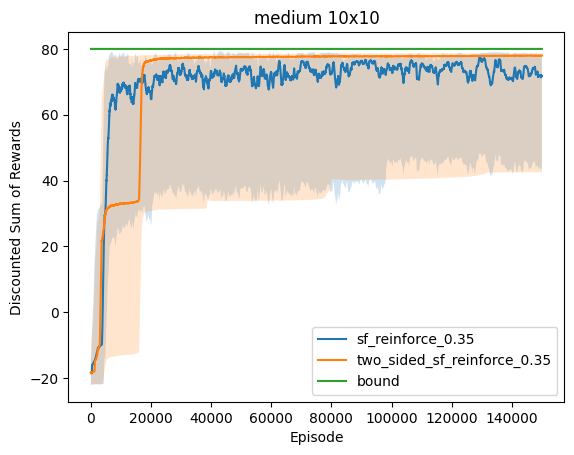

sf_reinforce_0.45 medium
10 150000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
4,"[-0.35, -6.25, -1.93, 2.36, -6.26, -5.36]","[4.51, -1.19, -3.09, -3.95, 2.36, 1.68]","[-3.99, -5.17, 0.8, 1.92, 3.93, 0.09]","[-1.99, 4.35, 1.15, -1.47, -1.6, -4.59]",2.69,0.08,0.24,-2.03,66.871986
6,"[-1.83, 3.4, 1.93, 3.8, -4.92, 1.67]","[5.55, 14.02, -1.67, 0.16, -4.28, -3.31]","[-3.51, -0.81, -0.32, 2.53, -1.14, 6.76]","[7.29, 4.25, 0.83, -3.67, 2.09, -4.24]",-4.66,-4.95,-7.80,-1.05,66.474167
3,"[-4.24, -0.8, 0.59, 1.9, 1.02, -4.97]","[-2.32, 3.73, -4.01, -2.79, 0.58, -2.66]","[-0.6, -5.0, -2.09, 1.28, 9.03, 0.86]","[6.63, -4.57, 2.04, -4.85, -2.81, -3.88]",-1.77,-8.51,-2.40,4.42,61.163958
0,"[4.41, -0.67, -5.58, 1.6, -1.08, -5.91]","[-3.24, 3.29, -4.8, 3.01, -2.78, -1.59]","[0.71, -1.23, -1.99, 3.68, 2.32, 1.37]","[-0.3, -3.34, 2.0, 0.89, 1.07, -4.82]",-0.91,6.92,1.42,0.86,54.474089
5,"[4.27, 1.97, 3.71, -3.45, 8.96, 0.38]","[-5.13, -2.15, -2.23, -8.21, 5.23, 8.8]","[-1.06, -3.75, 3.85, 7.2, 1.84, -0.53]","[-0.45, -8.72, 7.44, -0.83, -5.6, -2.61]",-0.18,-2.91,-5.98,2.12,53.737003
9,"[-0.37, -1.21, 1.83, -1.25, -2.49, -0.58]","[1.44, 3.39, -1.2, 2.32, 2.55, -0.19]","[-3.26, 1.88, 0.73, -3.6, 2.43, 1.48]","[-2.77, -2.35, 1.92, 5.37, -1.17, -0.5]",1.87,0.34,0.47,0.65,39.151426
2,"[0.57, 0.56, 0.15, -0.42, 0.29, 0.56]","[-1.83, -0.65, -0.8, -0.27, 1.54, 0.88]","[1.4, 1.03, -0.21, -0.43, 0.83, 0.59]","[-0.82, 0.31, -0.52, -0.72, 0.19, 0.41]",-0.65,-0.44,-1.11,-1.52,-0.960631
7,"[-0.19, -0.33, 0.53, -0.35, -0.71, -1.05]","[0.81, 1.12, 1.42, 0.22, 1.29, 0.44]","[-0.09, -0.23, -1.79, -1.14, -1.08, -0.81]","[0.12, 0.81, 0.81, -0.3, -0.11, -0.35]",-1.21,-0.10,-0.23,-0.65,-10.286174
1,"[0.5, -0.69, 0.19, 0.14, 0.25, 0.63]","[-1.2, 0.83, -0.06, 1.47, 0.16, 0.42]","[2.29, -0.99, 0.39, -0.59, -0.55, -0.28]","[0.68, 1.01, 0.32, 0.36, -0.82, -0.52]",-0.12,-0.12,0.60,-0.09,-11.728861
8,"[1.55, -1.12, -1.19, 2.3, 1.17, -0.53]","[-0.41, -1.19, -2.47, -0.72, 0.73, -0.39]","[-1.07, -0.27, 0.39, 0.07, 1.18, 0.48]","[0.86, -0.24, -1.34, 1.16, -0.72, -0.54]",0.89,0.65,-1.73,0.19,-13.682552


two_sided_sf_reinforce_0.45 medium
10 150000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
0,"[0.1, 0.11, -0.4, -0.22, -0.02, -0.02]","[0.02, 0.55, -0.1, 0.02, -0.16, 0.03]","[-0.43, -0.26, -0.14, 0.24, 0.22, 0.53]","[-0.32, -0.21, 0.08, 0.19, -0.09, 0.14]",-0.20,0.09,0.56,-0.51,78.787523
1,"[0.02, -0.39, -0.19, -0.11, -0.44, -0.05]","[-0.06, 0.26, 0.09, -0.13, -0.0, 0.08]","[0.17, -0.29, 0.06, 0.19, 0.1, 0.23]","[0.33, 0.22, -0.18, -0.34, -0.02, -0.32]",-0.26,-0.09,0.30,0.13,78.274820
4,"[0.1, 0.06, -0.32, -0.2, -0.29, -0.46]","[0.3, 0.48, 0.2, 0.28, -0.15, -0.19]","[0.34, -0.03, -0.02, 0.42, 0.21, 0.1]","[-0.17, -0.36, -0.14, -0.21, 0.11, -0.26]",0.28,0.00,0.44,0.04,78.274402
3,"[-0.34, -0.52, -0.09, -0.37, 0.06, -0.3]","[-0.04, 0.69, -0.15, 0.01, -0.08, 0.04]","[-0.0, -0.12, -0.16, 0.24, -0.13, 0.46]","[0.36, 0.24, -0.21, -0.29, 0.42, -0.14]",-0.37,-0.32,0.05,-0.14,78.202035
6,"[-0.01, -0.08, 0.26, -0.11, -0.14, -0.17]","[0.17, 0.28, 0.21, -0.08, -0.17, 0.36]","[0.04, 0.03, -0.23, 0.43, 0.43, 0.2]","[-0.09, -0.25, -0.31, -0.28, 0.03, -0.11]",-0.06,0.15,-0.06,-0.05,78.033917
5,"[0.46, -0.23, 0.1, 0.37, 0.26, -0.38]","[-0.33, 0.51, -0.33, 0.28, -0.01, 0.0]","[-0.31, -0.11, 0.22, 0.38, 0.51, 0.34]","[-0.45, 0.21, -0.01, -0.14, -0.35, 0.05]",0.24,-0.33,0.14,-0.08,77.940701
8,"[0.17, 0.18, 0.36, -0.37, 0.08, -0.18]","[0.31, -0.36, 0.09, -0.14, 0.45, 0.49]","[-0.17, -0.28, -0.34, 0.54, 0.25, 0.0]","[-0.06, -0.33, -0.31, -0.11, -0.37, -0.1]",0.17,-0.17,0.10,-0.22,77.930983
2,"[0.12, -0.13, 0.06, -0.15, 0.16, 0.0]","[0.01, -0.37, 0.27, -0.27, 0.12, 0.55]","[-0.12, 0.18, -0.03, 0.19, 0.2, -0.17]","[-0.25, 0.28, -0.54, -0.15, -0.05, -0.03]",0.02,0.18,0.11,-0.25,77.736263
7,"[0.03, -0.22, 0.15, -0.02, -0.3, -0.1]","[-0.08, 0.09, -0.17, 0.37, 0.41, 0.53]","[-0.18, -0.27, -0.12, -0.15, 0.27, -0.39]","[0.58, -0.48, 0.32, -0.3, 0.25, 0.07]",0.09,0.19,0.40,-0.04,-10.282234
9,"[0.1, -0.19, -0.04, 0.18, 0.36, 0.1]","[-0.21, 0.4, 0.0, 0.19, 0.38, 0.42]","[-0.32, -0.23, 0.04, 0.04, 0.05, -0.09]","[-0.04, 0.11, 0.02, 0.0, 0.33, 0.01]",-0.06,-0.27,0.33,0.17,-10.429174


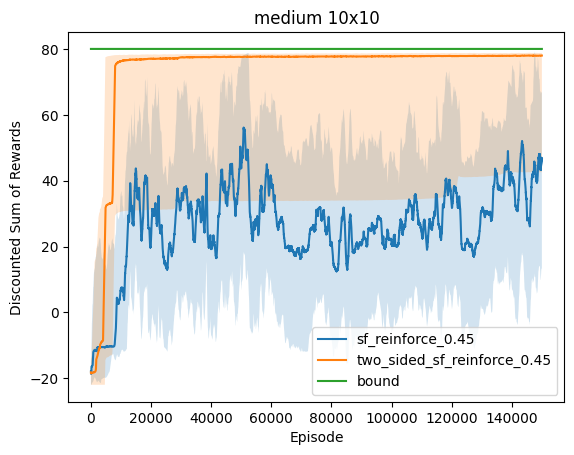

sf_reinforce_const_0.175 medium
10 150000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
1,"[0.08, -0.41, 0.01, -0.03, -0.48, -0.22]","[-0.11, 1.11, 0.01, -0.87, -0.03, 0.38]","[0.38, -1.05, 0.25, 1.41, 0.11, 0.2]","[0.35, 0.01, -0.11, -0.41, 0.11, -0.28]",-0.26,-0.03,0.66,0.19,74.877615
4,"[0.07, -0.16, -0.27, -0.16, -0.31, -0.5]","[0.78, 1.11, -0.01, -0.82, -0.31, 0.25]","[0.51, -0.51, 0.15, 1.59, 0.08, -0.36]","[-0.26, -0.58, -0.01, -0.21, -0.18, -0.28]",0.31,0.27,0.30,-0.08,74.527046
6,"[0.09, 0.25, 0.4, -0.25, -0.09, -0.42]","[0.15, 1.11, 0.05, -1.21, -0.14, 0.99]","[0.34, -0.27, 0.09, 1.44, 0.17, -0.01]","[-0.07, -0.39, -0.37, -0.35, -0.07, -0.17]",-0.04,-0.22,-0.13,0.14,74.433143
2,"[0.05, -0.19, 0.06, -0.43, 0.2, -0.15]","[-0.11, 0.47, 0.19, -1.17, 0.22, 1.14]","[-0.21, -0.2, 0.1, 1.51, 0.25, -0.37]","[-0.27, -0.06, -0.45, -0.35, -0.02, -0.43]",-0.29,0.18,-0.25,-0.31,73.942080
0,"[-0.21, 0.03, -0.31, -0.49, -0.12, -0.42]","[0.02, 1.3, -0.16, -0.79, 0.02, 0.59]","[-0.32, -0.94, -0.27, 1.24, 0.2, 0.77]","[-0.29, -0.41, 0.37, 0.23, -0.23, -0.18]",0.08,0.02,0.61,-0.27,73.871900
3,"[-0.54, -0.42, -0.25, -0.43, -0.12, -0.34]","[0.17, 1.03, 0.03, -0.94, -0.07, 0.48]","[-0.19, -1.02, -0.06, 1.26, -0.04, 0.37]","[0.12, 0.22, 0.19, -0.28, 0.22, -0.63]",-0.47,-0.32,-0.10,0.05,73.561516
8,"[-0.05, -0.12, 0.36, -0.68, -0.27, -0.25]","[0.58, 0.32, 0.07, -0.9, 0.48, 0.96]","[-0.35, -0.76, -0.51, 1.69, 0.17, -0.07]","[-0.14, -0.48, -0.09, -0.37, -0.33, 0.02]",0.10,-0.29,0.02,-0.10,73.486152
9,"[0.1, -0.29, -0.0, -0.02, 0.48, -0.16]","[-0.04, 1.22, -0.2, -0.92, 0.28, 0.54]","[-0.19, -0.67, -0.03, 1.3, -0.08, 0.26]","[-0.25, -0.06, -0.09, -0.02, 0.42, -0.27]",-0.06,-0.32,0.35,0.15,73.424335
5,"[0.56, -0.38, 0.22, 0.51, 0.28, -0.61]","[-0.3, 1.34, -0.25, -0.8, 0.19, 0.44]","[-0.34, -0.54, 0.23, 1.28, 0.64, 0.24]","[-0.32, 0.04, -0.21, -0.16, -0.45, -0.35]",0.16,-0.48,0.29,0.29,73.362068
7,"[0.05, -0.34, 0.04, -0.01, -0.31, -0.34]","[-0.17, 0.43, -0.07, -0.34, 0.33, 0.33]","[-0.11, -0.47, 0.01, 0.91, 0.14, 0.04]","[0.28, -0.41, 0.27, -0.22, 0.15, -0.28]",-0.07,0.11,0.40,0.05,63.511640


two_sided_sf_reinforce_const_0.175 medium
10 150000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
1,"[0.16, -0.36, -0.14, -0.1, -0.37, -0.22]","[-0.02, 1.04, -0.0, -1.02, 0.14, 0.57]","[0.12, -0.74, 0.1, 1.31, 0.08, 0.11]","[0.33, 0.03, -0.21, -0.32, -0.11, -0.35]",-0.21,0.08,0.34,0.13,74.434300
0,"[-0.02, 0.08, -0.39, -0.32, -0.18, -0.21]","[0.06, 1.32, -0.11, -0.9, -0.13, 0.44]","[-0.36, -0.87, 0.02, 1.25, 0.17, 0.46]","[-0.31, -0.41, 0.12, 0.1, -0.09, -0.12]",-0.07,0.06,0.47,-0.41,74.366220
3,"[-0.44, -0.34, -0.17, -0.4, -0.02, -0.39]","[0.26, 1.1, -0.01, -0.92, -0.04, 0.43]","[-0.3, -0.92, -0.23, 1.31, -0.21, 0.32]","[0.24, 0.23, 0.09, -0.32, 0.31, -0.53]",-0.32,-0.24,0.02,-0.01,74.112300
8,"[0.05, -0.0, 0.31, -0.49, -0.03, -0.33]","[0.37, 0.39, 0.04, -1.03, 0.36, 0.86]","[-0.26, -0.79, -0.29, 1.57, 0.27, -0.16]","[-0.05, -0.41, -0.32, -0.21, -0.33, -0.24]",0.12,-0.27,0.03,-0.11,73.692732
2,"[0.06, -0.18, 0.02, -0.29, 0.15, -0.18]","[0.02, 0.59, 0.12, -1.11, 0.1, 0.99]","[-0.07, -0.22, 0.1, 1.46, 0.16, -0.36]","[-0.22, 0.12, -0.47, -0.36, -0.04, -0.22]",-0.11,0.18,0.05,-0.33,73.672634
4,"[0.02, 0.01, -0.36, -0.23, -0.37, -0.51]","[0.47, 1.17, 0.0, -0.8, -0.12, 0.23]","[0.33, -0.68, 0.2, 1.5, 0.23, -0.15]","[-0.19, -0.5, -0.02, -0.21, 0.04, -0.38]",0.24,0.09,0.34,0.01,73.639424
6,"[0.05, -0.02, 0.29, -0.12, -0.22, -0.34]","[0.21, 1.05, 0.04, -1.09, -0.13, 0.75]","[0.1, -0.46, -0.08, 1.39, 0.31, 0.01]","[-0.15, -0.26, -0.33, -0.32, -0.16, -0.09]",-0.01,0.01,-0.10,0.12,73.621984
9,"[0.08, -0.33, -0.07, 0.01, 0.34, -0.18]","[-0.14, 1.09, -0.11, -0.88, 0.41, 0.63]","[-0.3, -0.67, 0.17, 1.28, 0.05, 0.29]","[-0.07, -0.08, 0.07, -0.02, 0.3, -0.26]",-0.13,-0.31,0.47,0.12,73.560490
5,"[0.27, -0.33, 0.32, 0.14, 0.35, -0.39]","[-0.16, 1.17, -0.44, -0.81, 0.07, 0.57]","[-0.32, -0.64, 0.31, 1.4, 0.4, 0.19]","[-0.4, 0.11, 0.04, -0.22, -0.38, -0.23]",0.25,-0.25,0.17,0.04,73.463406
7,"[0.01, -0.32, 0.07, -0.1, -0.22, -0.31]","[-0.21, 0.58, -0.12, -0.43, 0.31, 0.32]","[-0.12, -0.56, 0.06, 0.93, 0.19, 0.1]","[0.35, -0.41, 0.25, -0.2, 0.16, -0.31]",-0.02,0.12,0.37,0.02,66.355861


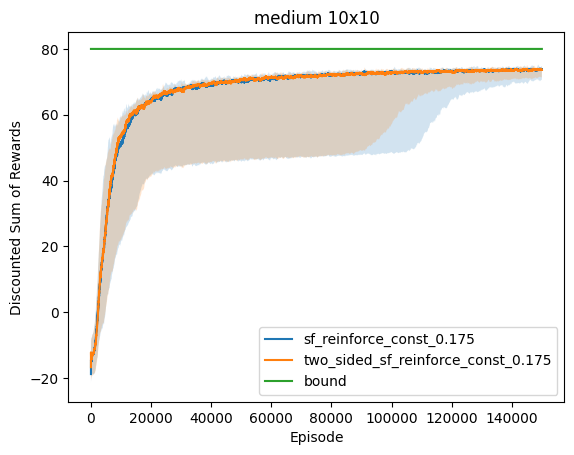

sf_reinforce_const_0.5 medium
10 150000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
6,"[-0.03, -0.14, 0.3, -0.34, -0.19, -0.66]","[0.22, 1.36, 0.02, -1.19, -0.13, 1.16]","[0.16, -0.53, -0.02, 1.79, 0.33, 0.29]","[-0.14, -0.44, -0.31, -0.49, -0.14, -0.44]",0.02,-0.02,-0.12,0.21,56.288546
3,"[-0.46, -0.37, -0.21, -0.56, -0.06, -0.63]","[0.34, 1.33, 0.01, -1.01, -0.02, 0.92]","[-0.29, -0.82, -0.15, 1.71, -0.24, 0.49]","[0.19, 0.08, 0.05, -0.49, 0.37, -0.9]",-0.35,-0.22,-0.05,-0.00,55.131899
8,"[-0.05, -0.09, 0.3, -0.62, -0.08, -0.65]","[0.45, 0.7, 0.07, -1.1, 0.37, 1.31]","[-0.25, -0.75, -0.26, 2.04, 0.26, 0.08]","[-0.08, -0.53, -0.31, -0.4, -0.38, -0.6]",0.13,-0.26,-0.07,-0.17,54.977452
4,"[-0.0, -0.12, -0.39, -0.41, -0.44, -0.86]","[0.52, 1.39, 0.02, -0.89, -0.14, 0.7]","[0.39, -0.67, 0.23, 1.91, 0.28, 0.05]","[-0.28, -0.56, -0.04, -0.34, 0.07, -0.71]",0.28,0.07,0.34,-0.05,54.665142
1,"[0.13, -0.46, -0.18, -0.3, -0.38, -0.56]","[0.02, 1.29, 0.05, -1.07, 0.11, 0.98]","[0.14, -0.76, 0.18, 1.69, 0.08, 0.35]","[0.31, -0.16, -0.16, -0.45, -0.07, -0.74]",-0.21,0.10,0.30,0.15,54.442569
0,"[-0.09, -0.06, -0.37, -0.53, -0.16, -0.51]","[0.06, 1.52, -0.05, -0.87, -0.11, 0.87]","[-0.32, -0.87, 0.06, 1.62, 0.18, 0.73]","[-0.36, -0.47, 0.08, -0.06, -0.15, -0.52]",-0.14,0.11,0.41,-0.48,51.824962
9,"[0.06, -0.43, -0.11, -0.17, 0.32, -0.49]","[-0.1, 1.37, -0.08, -0.91, 0.35, 1.04]","[-0.25, -0.59, 0.21, 1.65, 0.05, 0.5]","[-0.08, -0.19, 0.09, -0.16, 0.28, -0.59]",-0.09,-0.22,0.42,0.13,51.016069
2,"[0.05, -0.24, -0.01, -0.5, 0.14, -0.48]","[0.09, 0.66, 0.12, -0.97, 0.05, 1.37]","[-0.12, -0.06, 0.21, 1.71, 0.12, -0.13]","[-0.24, -0.01, -0.51, -0.46, -0.07, -0.53]",-0.09,0.22,0.05,-0.32,50.728669
5,"[0.22, -0.45, 0.28, -0.04, 0.32, -0.73]","[-0.19, 1.4, -0.43, -0.72, 0.1, 0.96]","[-0.32, -0.52, 0.4, 1.67, 0.43, 0.46]","[-0.45, -0.01, 0.09, -0.38, -0.38, -0.55]",0.32,-0.26,0.17,0.04,49.982213
7,"[-0.03, -0.47, 0.02, -0.25, -0.25, -0.68]","[-0.2, 0.98, -0.12, -0.73, 0.32, 0.85]","[-0.18, -0.65, 0.16, 1.61, 0.25, 0.21]","[0.32, -0.61, 0.27, -0.39, 0.2, -0.62]",-0.02,0.10,0.41,0.01,49.733958


two_sided_sf_reinforce_const_0.5 medium
10 150000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
4,"[0.01, -0.15, -0.34, -0.43, -0.39, -0.84]","[0.52, 1.39, 0.07, -0.88, -0.11, 0.69]","[0.36, -0.69, 0.22, 1.92, 0.24, 0.07]","[-0.24, -0.61, -0.08, -0.36, 0.07, -0.71]",0.28,0.14,0.30,0.03,56.800888
8,"[0.03, -0.06, 0.3, -0.68, -0.03, -0.67]","[0.44, 0.66, 0.08, -1.09, 0.36, 1.3]","[-0.27, -0.74, -0.23, 2.01, 0.27, 0.07]","[-0.1, -0.52, -0.36, -0.4, -0.35, -0.58]",0.14,-0.24,-0.03,-0.09,55.458755
3,"[-0.44, -0.41, -0.21, -0.52, -0.02, -0.63]","[0.29, 1.34, 0.01, -1.03, -0.02, 0.91]","[-0.3, -0.86, -0.19, 1.71, -0.23, 0.49]","[0.24, 0.05, 0.07, -0.48, 0.33, -0.89]",-0.34,-0.22,-0.05,-0.04,55.301445
1,"[0.13, -0.5, -0.16, -0.32, -0.4, -0.54]","[0.02, 1.3, 0.01, -1.05, 0.16, 1.0]","[0.17, -0.72, 0.16, 1.68, 0.07, 0.37]","[0.29, -0.12, -0.21, -0.46, -0.1, -0.72]",-0.22,0.10,0.31,0.14,54.846652
6,"[0.0, -0.17, 0.31, -0.36, -0.22, -0.67]","[0.24, 1.36, 0.05, -1.13, -0.13, 1.14]","[0.12, -0.46, -0.04, 1.8, 0.33, 0.26]","[-0.15, -0.41, -0.37, -0.47, -0.15, -0.46]",-0.00,0.02,-0.15,0.15,54.637816
0,"[-0.06, -0.05, -0.38, -0.52, -0.16, -0.54]","[0.09, 1.54, -0.08, -0.89, -0.12, 0.86]","[-0.35, -0.85, -0.01, 1.61, 0.18, 0.71]","[-0.34, -0.52, 0.08, -0.05, -0.11, -0.51]",-0.11,0.09,0.46,-0.44,54.456050
9,"[0.05, -0.45, -0.11, -0.2, 0.31, -0.48]","[-0.1, 1.36, -0.09, -0.85, 0.39, 0.99]","[-0.26, -0.63, 0.21, 1.6, 0.07, 0.54]","[-0.11, -0.22, 0.05, -0.14, 0.28, -0.6]",-0.14,-0.28,0.45,0.13,51.621478
5,"[0.25, -0.43, 0.25, -0.05, 0.32, -0.75]","[-0.17, 1.37, -0.42, -0.7, 0.11, 0.94]","[-0.33, -0.55, 0.36, 1.7, 0.44, 0.43]","[-0.43, -0.01, 0.08, -0.43, -0.43, -0.56]",0.28,-0.24,0.12,0.06,50.708022
2,"[0.05, -0.29, 0.0, -0.5, 0.14, -0.47]","[0.07, 0.7, 0.17, -0.97, 0.09, 1.31]","[-0.1, -0.1, 0.16, 1.73, 0.2, -0.14]","[-0.22, -0.0, -0.5, -0.49, -0.05, -0.53]",-0.10,0.19,0.01,-0.28,50.135411
7,"[-0.01, -0.46, 0.05, -0.26, -0.23, -0.65]","[-0.16, 0.97, -0.13, -0.67, 0.31, 0.81]","[-0.14, -0.63, 0.13, 1.53, 0.21, 0.26]","[0.3, -0.59, 0.22, -0.39, 0.17, -0.61]",-0.04,0.14,0.40,0.03,46.366635


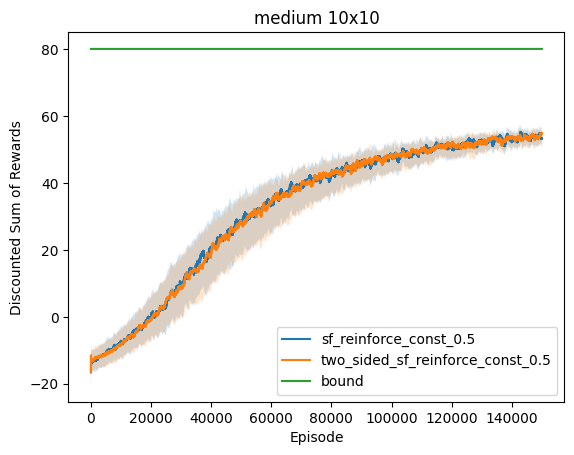

In [7]:
gridsizes = ["4x4", "8x8", "10x10", "20x20", "50x50"]
for grid, gridsize in zip(["medium"], ["10x10"]):
    for suffix in "0.101 0.15 0.25 0.35 0.45 const_0.175 const_0.5".split():
        for algo in "sf_reinforce two_sided_sf_reinforce".split():
            name = algo + "_" + suffix
            dirname = os.path.join("saves", name, grid)
            filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
            path = os.path.join(dirname, filename)
            print(name, grid)
            avg_rewards, bot, top = get_results(path, 800)
            plt.plot(avg_rewards, label=name)
            plt.fill_between(range(len(avg_rewards)), bot, top, alpha=0.2)
        plt.plot([80] * len(avg_rewards), label="bound")
        plt.title(f"{grid} {gridsize}")
        plt.xlabel('Episode')
        plt.ylabel('Discounted Sum of Rewards')
        plt.legend()
        plt.show()


0.15 0.17402271240926254
0.25 0.054344194757983286
0.35 0.016996511436359246
0.45000000000000007 0.005323956688094775


Text(0.5, 1.0, 'Different exp-decay schemes for delta')

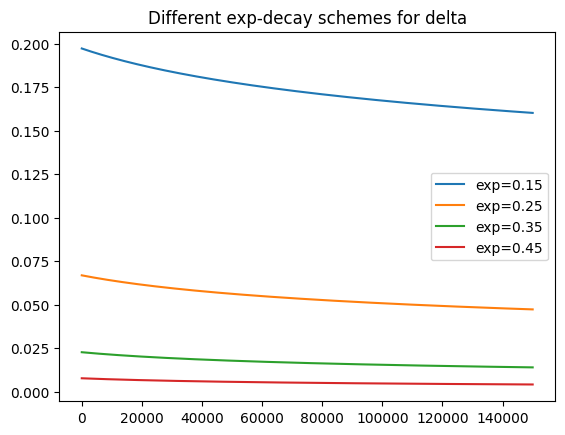

In [9]:
from spsa import get_delta

for delta_pow in np.arange(0.15, 0.5, 0.1):
    ep = np.arange(150000)
    delta = get_delta(ep, delta_pow, None)
    print(delta_pow, delta.mean())
    plt.plot(ep, delta, label="exp="+str(round(delta_pow, 2)))

# for const_delta in [0.175, 0.5]:
#     ep = np.arange(150000)
#     delta = np.ones_like(ep) * const_delta
#     plt.plot(ep, delta, label="const_delta="+str(round(const_delta, 3)))

plt.legend();
plt.title("Different exp-decay schemes for delta")


In [10]:
# table for experiment 1 different sizes, different algorithm
frame = []
gridsizes = ["4x4", "8x8", "10x10", "20x20", "50x50"]
for algo in "reinforce sf_reinforce two_sided_sf_reinforce".split():
    for grid, gridsize in zip("tiny small medium medium20 large".split(), gridsizes):
        dirname = os.path.join("saves", algo, grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        with open(path, "rb") as file:
            results = np.array(pickle.load(file))

        per_seed_results = results[:, -200:].mean(1)
        disp = f"{per_seed_results.mean():.2f} +- {per_seed_results.std():.1f}"
        frame.append((algo, gridsize, disp))
frame = pd.DataFrame(frame).pivot(index=0, columns=1).reset_index()
frame.columns = ["Algorithm / Gridsize"] + [col for _, col in frame.columns][1:]
display(frame)
print(
    frame[["Algorithm / Gridsize"] + gridsizes]
    .to_latex(index=False, escape=True)
    .replace("toprule", "hline")
    .replace("bottomrule", "hline")
    .replace("midrule", "hline")
    .replace("+-", "$\\pm$")
)


,Algorithm / Gridsize,10x10,20x20,4x4,50x50,8x8
0,reinforce,76.90 +- 4.9,144.89 +- 113.8,13.90 +- 0.1,-18.79 +- 8.4,50.74 +- 2.3
1,sf_reinforce,59.80 +- 35.0,220.24 +- 78.8,13.23 +- 0.1,376.29 +- 401.4,45.40 +- 17.7
2,two_sided_sf_reinforce,60.39 +- 35.0,170.68 +- 127.4,13.26 +- 0.1,562.89 +- 387.7,45.52 +- 17.8


\begin{tabular}{llllll}
\hline
Algorithm / Gridsize & 4x4 & 8x8 & 10x10 & 20x20 & 50x50 \\
\hline
reinforce & 13.90 $\pm$ 0.1 & 50.74 $\pm$ 2.3 & 76.90 $\pm$ 4.9 & 144.89 $\pm$ 113.8 & -18.79 $\pm$ 8.4 \\
sf\_reinforce & 13.23 $\pm$ 0.1 & 45.40 $\pm$ 17.7 & 59.80 $\pm$ 35.0 & 220.24 $\pm$ 78.8 & 376.29 $\pm$ 401.4 \\
two\_sided\_sf\_reinforce & 13.26 $\pm$ 0.1 & 45.52 $\pm$ 17.8 & 60.39 $\pm$ 35.0 & 170.68 $\pm$ 127.4 & 562.89 $\pm$ 387.7 \\
\hline
\end{tabular}



In [11]:
# table for experiment 2 different decays
frame = []
grid, gridsize = "medium", "10x10"
for algo in "sf_reinforce two_sided_sf_reinforce".split():
    for decay in [0.101, 0.15, 0.25, 0.35, 0.45]:
        dirname = os.path.join("saves", f"{algo}_{decay}", grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        with open(path, "rb") as file:
            results = np.array(pickle.load(file))

        per_seed_results = results[:, -200:].mean(1)
        disp = f"{per_seed_results.mean():.2f} +- {per_seed_results.std():.1f}"
        frame.append((algo, decay, disp))
frame = pd.DataFrame(frame).pivot(index=0, columns=1).reset_index()
frame.columns = ["Algorithm / Decay"] + [col for _, col in frame.columns][1:]
display(frame)
print(
    frame
    .to_latex(index=False, escape=True)
    .replace("toprule", "hline")
    .replace("bottomrule", "hline")
    .replace("midrule", "hline")
    .replace("+-", "$\\pm$")
)


,Algorithm / Decay,0.101,0.15,0.25,0.35,0.45
0,sf_reinforce,68.72 +- 1.5,74.07 +- 0.7,59.45 +- 35.0,62.60 +- 28.4,31.33 +- 34.0
1,two_sided_sf_reinforce,68.10 +- 1.3,74.18 +- 0.6,68.49 +- 26.3,60.40 +- 35.4,60.46 +- 35.4


\begin{tabular}{llllll}
\hline
Algorithm / Decay & 0.101000 & 0.150000 & 0.250000 & 0.350000 & 0.450000 \\
\hline
sf\_reinforce & 68.72 $\pm$ 1.5 & 74.07 $\pm$ 0.7 & 59.45 $\pm$ 35.0 & 62.60 $\pm$ 28.4 & 31.33 $\pm$ 34.0 \\
two\_sided\_sf\_reinforce & 68.10 $\pm$ 1.3 & 74.18 $\pm$ 0.6 & 68.49 $\pm$ 26.3 & 60.40 $\pm$ 35.4 & 60.46 $\pm$ 35.4 \\
\hline
\end{tabular}



In [12]:
# table for experiment 2 different decays
frame = []
grid, gridsize = "medium", "10x10"
for algo in "sf_reinforce two_sided_sf_reinforce".split():
    for const in [0.175, 0.5]:
        dirname = os.path.join("saves", f"{algo}_const_{const}", grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        with open(path, "rb") as file:
            results = np.array(pickle.load(file))

        per_seed_results = results[:, -200:].mean(1)
        disp = f"{per_seed_results.mean():.2f} +- {per_seed_results.std():.1f}"
        frame.append((algo, const, disp))
frame = pd.DataFrame(frame).pivot(index=0, columns=1).reset_index()
frame.columns = ["Algorithm / Decay"] + [col for _, col in frame.columns][1:]
display(frame)
print(
    frame
    .to_latex(index=False, escape=True)
    .replace("toprule", "hline")
    .replace("bottomrule", "hline")
    .replace("midrule", "hline")
    .replace("+-", "$\\pm$")
)


,Algorithm / Decay,0.175,0.5
0,sf_reinforce,72.66 +- 3.6,52.60 +- 2.8
1,two_sided_sf_reinforce,73.29 +- 1.9,53.10 +- 3.2


\begin{tabular}{lll}
\hline
Algorithm / Decay & 0.175000 & 0.500000 \\
\hline
sf\_reinforce & 72.66 $\pm$ 3.6 & 52.60 $\pm$ 2.8 \\
two\_sided\_sf\_reinforce & 73.29 $\pm$ 1.9 & 53.10 $\pm$ 3.2 \\
\hline
\end{tabular}



In [13]:
frame = []
grid, gridsize = "large", "50x50"
for algo in "sf_reinforce two_sided_sf_reinforce".split():
    for const in [0.175, 0.5, 0.7]:
        dirname = os.path.join("saves", f"{algo}_const_{const}", grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        with open(path, "rb") as file:
            results = np.array(pickle.load(file))

        per_seed_results = results[:, -200:].mean(1)
        disp = f"{per_seed_results.mean():.2f} +- {per_seed_results.std():.1f}"
        frame.append((algo, const, disp))
frame = pd.DataFrame(frame).pivot(index=0, columns=1).reset_index()
frame.columns = ["Algorithm / Decay"] + [col for _, col in frame.columns][1:]
display(frame)
print(
    frame
    .to_latex(index=False, escape=True)
    .replace("toprule", "hline")
    .replace("bottomrule", "hline")
    .replace("midrule", "hline")
    .replace("+-", "$\\pm$")
)


,Algorithm / Decay,0.175,0.5,0.7
0,sf_reinforce,677.55 +- 233.1,446.65 +- 26.8,254.74 +- 35.6
1,two_sided_sf_reinforce,665.50 +- 229.1,437.26 +- 21.7,247.09 +- 33.0


\begin{tabular}{llll}
\hline
Algorithm / Decay & 0.175000 & 0.500000 & 0.700000 \\
\hline
sf\_reinforce & 677.55 $\pm$ 233.1 & 446.65 $\pm$ 26.8 & 254.74 $\pm$ 35.6 \\
two\_sided\_sf\_reinforce & 665.50 $\pm$ 229.1 & 437.26 $\pm$ 21.7 & 247.09 $\pm$ 33.0 \\
\hline
\end{tabular}



sf_reinforce_const_0.175 large
10 200000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
4,"[-2.51, 0.48, 1.8, -0.98, 2.56, -1.1]","[1.05, 4.57, -0.5, -4.41, -0.07, -0.2]","[1.45, -7.11, 1.65, 5.82, -2.52, 1.1]","[-0.82, -1.16, -1.65, 2.55, 0.81, -3.51]",1.63,0.63,2.09,-1.91,768.760224
5,"[0.03, 1.53, -0.08, -0.22, 0.45, -0.41]","[0.33, 5.56, -2.81, -5.7, 0.43, 2.46]","[-1.4, -3.32, -1.33, 5.44, 0.59, 0.28]","[-2.5, -0.07, 0.01, 0.02, -0.9, -1.59]",-0.44,0.32,-2.86,-0.32,764.196789
9,"[-0.69, -1.6, 0.28, 0.9, 0.04, -0.92]","[-0.32, 4.76, -2.07, -4.7, 0.34, 3.34]","[1.19, -1.99, 0.13, 6.39, -0.98, -0.84]","[0.89, 0.95, 0.37, 0.07, 1.51, 0.34]",-1.46,-1.00,0.84,-0.50,760.939375
6,"[0.02, -3.63, -0.85, -2.26, -3.31, -0.91]","[-0.12, 2.46, 1.16, -4.36, -0.97, 2.64]","[3.19, -4.2, -1.88, 6.64, 0.85, -1.41]","[-2.02, 0.63, 0.32, 0.74, -4.36, -1.66]",-0.91,-0.66,1.62,-0.46,760.751625
8,"[0.24, 1.65, 0.48, -2.64, -1.83, -1.49]","[1.11, 5.0, -1.07, -5.22, -0.18, 1.8]","[-0.68, -2.75, -0.93, 4.85, 3.67, -0.43]","[1.18, 1.26, -0.4, -1.61, 0.98, -3.08]",-1.16,0.61,-0.03,-3.00,750.859100
1,"[-1.77, 1.48, 0.68, -1.41, -1.23, -3.11]","[0.71, 3.45, -0.66, -4.06, 0.29, 1.94]","[0.18, -4.19, -0.74, 5.94, 0.73, -0.26]","[0.17, -1.1, -1.71, 0.87, -3.19, -1.45]",-0.08,1.10,-1.12,1.16,750.688152
0,"[3.2, -2.42, 0.84, 1.85, 0.04, -1.74]","[0.26, 5.34, -0.34, -4.14, -1.87, 2.9]","[0.09, -1.25, 1.15, 5.48, -0.54, 0.0]","[-1.41, 1.46, 1.88, 0.39, -0.65, 0.22]",-2.19,1.77,1.69,-0.86,748.711766
2,"[-0.63, 0.76, -1.61, 0.45, 1.27, -1.06]","[-0.14, 3.84, -0.04, -4.27, -0.25, 2.25]","[-1.11, -1.38, 0.43, 5.92, -1.45, -2.48]","[-1.81, 0.75, -1.67, -3.27, -0.68, 0.01]",-0.01,1.88,-1.41,-1.64,737.250067
3,"[-0.69, -0.06, 0.04, -2.55, -1.24, -1.01]","[1.06, 2.87, -0.52, -3.15, 0.1, 1.48]","[0.7, -2.94, -0.26, 5.65, -0.28, -1.37]","[-0.72, 1.52, 0.97, 0.03, -1.2, -2.48]",1.05,-1.40,1.19,-1.69,719.135201
7,"[-0.02, -0.16, 0.09, -0.07, -0.25, -0.07]","[-0.18, 0.13, -0.09, 0.63, 0.31, 0.43]","[-0.06, -0.19, -0.03, -0.16, 0.18, -0.34]","[0.47, -0.34, 0.28, -0.17, 0.07, -0.18]",0.04,0.11,0.30,0.11,-21.163492


two_sided_sf_reinforce_const_0.175 large
10 200000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
0,"[-0.1, 0.13, -0.33, -0.29, 0.17, -0.35]","[0.19, 4.01, -0.24, -4.5, -0.23, 1.54]","[-0.4, -3.18, -0.13, 4.88, 0.56, -0.52]","[-0.21, -0.6, 0.24, 0.05, -0.08, -0.3]",-0.37,0.23,0.89,-0.59,750.961194
1,"[0.15, -0.45, -0.29, 0.01, -0.34, -0.33]","[-0.05, 3.62, 0.08, -4.45, 0.28, 1.75]","[0.04, -3.17, 0.22, 4.94, 0.23, -0.72]","[0.6, 0.28, -0.34, -0.5, -0.26, -0.23]",-0.49,0.31,0.58,-0.22,747.391217
6,"[0.05, -0.25, 0.28, 0.16, -0.29, -0.58]","[0.12, 3.63, 0.08, -4.77, -0.06, 1.99]","[0.03, -2.87, -0.07, 4.77, 0.36, -0.86]","[-0.01, -0.01, -0.57, -0.21, 0.03, -0.42]",-0.33,0.31,0.30,-0.26,747.289056
4,"[-0.04, -0.11, -0.2, -0.4, -0.51, -0.67]","[0.64, 3.63, 0.09, -4.65, -0.14, 1.3]","[0.07, -3.18, 0.36, 4.89, 0.35, -1.27]","[-0.1, -0.39, 0.16, -0.11, 0.25, -0.72]",-0.02,0.38,0.81,-0.15,744.002781
8,"[-0.09, -0.0, 0.09, -0.72, 0.11, -0.37]","[0.35, 3.2, -0.08, -4.4, 0.35, 1.75]","[-0.22, -3.42, -0.09, 5.04, 0.04, -0.89]","[-0.12, -0.33, -0.56, -0.2, -0.31, -0.27]",-0.21,0.22,0.55,-0.33,743.891198
3,"[-0.2, -0.4, -0.28, -0.4, -0.07, -0.28]","[0.28, 3.69, 0.23, -4.41, 0.01, 1.69]","[-0.16, -3.07, -0.08, 5.02, -0.19, -0.82]","[0.29, 0.18, 0.03, -0.29, 0.26, -0.52]",-0.62,0.07,0.62,-0.45,740.031643
2,"[-0.03, -0.18, -0.08, -0.41, 0.32, -0.2]","[-0.16, 2.82, 0.21, -4.22, 0.13, 2.09]","[-0.05, -2.66, 0.23, 4.78, 0.12, -1.24]","[-0.04, 0.12, -0.5, -0.52, 0.24, -0.33]",-0.37,0.29,0.33,-0.39,737.984560
5,"[0.3, -0.41, 0.28, 0.42, 0.26, -0.32]","[-0.33, 3.72, -0.43, -4.2, 0.17, 1.89]","[-0.33, -3.02, 0.31, 5.09, 0.36, -0.53]","[-0.4, -0.1, 0.26, -0.17, -0.06, -0.41]",-0.06,0.24,0.72,-0.07,737.853732
9,"[0.27, -0.27, -0.09, 0.05, 0.27, -0.39]","[-0.13, 3.52, -0.21, -4.15, 0.05, 1.62]","[-0.35, -2.93, 0.17, 4.46, -0.08, -0.43]","[-0.09, -0.08, 0.28, -0.04, 0.15, -0.28]",-0.44,-0.22,0.75,-0.22,725.587516
7,"[0.03, -0.26, 0.11, -0.08, -0.22, -0.13]","[-0.23, 0.11, -0.04, 0.59, 0.31, 0.42]","[-0.17, -0.22, -0.04, -0.08, 0.17, -0.29]","[0.37, -0.34, 0.27, -0.17, 0.2, -0.22]",0.00,0.13,0.31,0.07,-21.179135


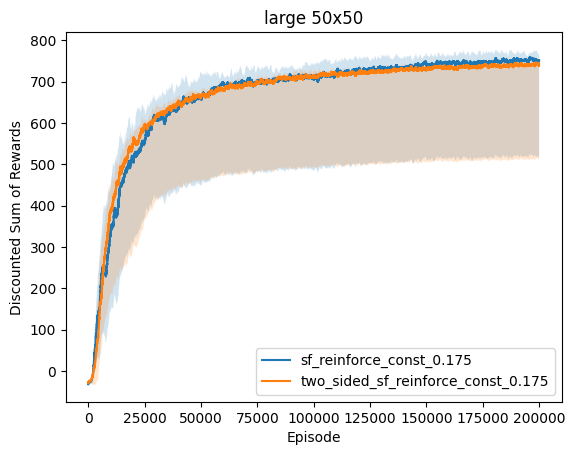

sf_reinforce_const_0.5 large
10 200000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
6,"[0.04, -0.44, 0.65, -0.31, -0.54, -1.21]","[-0.2, 3.83, 0.08, -4.1, 0.03, 1.92]","[0.31, -3.18, -0.16, 5.16, 0.16, -0.19]","[0.32, -0.26, -0.54, -0.66, 0.22, -0.63]",-0.51,0.10,-0.17,-0.18,471.827652
4,"[-0.07, 0.18, 0.24, -0.68, -0.88, -1.0]","[0.59, 4.11, 0.46, -4.01, -0.27, 1.87]","[0.37, -2.58, 0.15, 5.36, 0.17, -0.62]","[0.15, -0.64, 0.3, -0.29, 0.0, -0.92]",0.21,0.13,0.39,-0.20,470.048178
8,"[-0.33, -0.23, 0.52, -0.46, -0.37, -1.04]","[0.22, 3.01, 0.08, -4.03, 0.11, 2.37]","[-0.16, -3.02, -0.32, 5.16, 0.36, -0.57]","[0.59, -0.98, -0.6, -0.46, -0.15, -0.79]",0.03,-0.40,0.45,-0.50,463.285428
3,"[-0.57, -0.91, -0.26, -0.42, 0.34, -1.09]","[-0.38, 3.39, -0.24, -3.72, 0.2, 1.75]","[-0.33, -3.05, -0.05, 4.91, -0.57, -0.32]","[0.6, 0.12, -0.24, -0.51, 0.15, -1.01]",-0.66,-0.08,0.40,-0.28,450.603378
9,"[-0.16, -0.54, -0.21, -0.36, 0.3, -0.29]","[-0.36, 3.62, 0.04, -3.76, 0.24, 2.33]","[-0.17, -2.49, 0.4, 4.57, -0.36, 0.23]","[0.08, -0.6, 0.14, -0.15, 0.37, -0.4]",-0.01,-0.20,0.88,-0.01,440.941184
5,"[0.63, -0.58, 0.37, -0.05, 0.13, -1.16]","[-0.45, 3.67, -0.35, -3.77, 0.04, 2.05]","[-0.03, -2.33, -0.08, 5.08, -0.13, -0.63]","[-0.55, 0.18, 0.03, -0.59, -0.6, -1.06]",0.15,-0.22,-0.05,-0.30,437.723023
0,"[0.4, -0.03, -0.29, -0.47, -0.41, -0.76]","[-0.19, 3.72, 0.04, -3.93, 0.02, 2.14]","[-0.12, -3.13, 0.04, 5.07, -0.3, 0.15]","[-0.79, -0.54, 0.38, 0.13, 0.16, -1.11]",-0.45,-0.06,0.30,-0.60,434.547155
2,"[-0.07, -0.35, 0.17, -0.59, 0.73, -0.83]","[0.17, 2.73, 0.15, -3.58, 0.03, 2.5]","[-0.28, -2.32, -0.19, 5.07, 0.25, -0.83]","[-0.24, -0.14, -0.44, -0.82, 0.32, -0.63]",-0.28,0.36,-0.36,-0.16,424.226468
1,"[0.04, -0.21, 0.44, -0.34, -0.42, -0.97]","[0.33, 3.62, -0.16, -3.63, 0.05, 2.18]","[0.11, -2.43, 0.21, 4.59, 0.05, 0.14]","[0.18, -0.31, -0.06, -0.7, -0.43, -0.92]",-0.28,0.53,0.39,-0.33,420.284572
7,"[0.23, -0.81, 0.23, -0.42, -0.41, -0.9]","[-0.26, 3.22, -0.0, -3.48, 0.22, 2.12]","[0.04, -2.38, 0.04, 4.42, 0.18, -0.03]","[0.54, -0.48, 0.19, -0.32, -0.12, -0.89]",-0.07,0.02,0.38,0.16,410.367642


two_sided_sf_reinforce_const_0.5 large
10 200000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
4,"[-0.02, -0.25, -0.41, -0.51, -0.36, -1.13]","[0.42, 3.55, 0.09, -3.94, -0.1, 1.96]","[0.45, -2.77, 0.24, 5.15, 0.2, -0.63]","[-0.25, -0.58, -0.13, -0.47, 0.03, -1.04]",0.11,0.29,0.54,-0.08,461.957824
6,"[0.03, -0.34, 0.33, -0.42, -0.26, -1.04]","[0.1, 3.63, -0.01, -4.22, -0.06, 2.27]","[0.11, -2.86, -0.15, 5.04, 0.29, -0.31]","[0.05, -0.45, -0.34, -0.65, -0.09, -0.78]",-0.16,0.21,0.09,-0.09,460.795234
3,"[-0.42, -0.53, -0.25, -0.61, 0.0, -0.88]","[0.19, 3.74, -0.01, -4.14, -0.07, 2.0]","[-0.23, -3.07, -0.24, 4.97, -0.2, -0.14]","[0.22, -0.09, 0.03, -0.69, 0.31, -1.07]",-0.48,-0.05,0.08,-0.25,456.393637
8,"[0.15, -0.26, 0.24, -0.85, 0.03, -0.82]","[0.45, 3.02, 0.08, -3.96, 0.39, 2.41]","[-0.31, -2.88, -0.31, 5.3, 0.24, -0.7]","[-0.02, -0.56, -0.38, -0.6, -0.27, -0.77]",-0.16,-0.08,0.24,-0.31,454.274304
1,"[0.08, -0.61, -0.25, -0.28, -0.31, -0.86]","[0.01, 3.54, 0.03, -4.03, 0.08, 2.2]","[0.15, -2.86, 0.14, 4.88, 0.06, -0.16]","[0.37, -0.2, -0.2, -0.58, -0.16, -0.93]",-0.30,0.18,0.50,-0.00,448.417196
5,"[0.21, -0.47, 0.23, -0.06, 0.34, -0.95]","[-0.23, 3.57, -0.32, -3.65, 0.24, 2.08]","[-0.36, -2.65, 0.23, 4.88, 0.36, -0.09]","[-0.31, -0.05, 0.11, -0.61, -0.33, -0.83]",0.03,-0.19,0.40,-0.11,438.492694
0,"[-0.07, -0.2, -0.31, -0.58, -0.19, -0.73]","[0.1, 3.81, -0.13, -3.82, -0.25, 2.0]","[-0.44, -2.85, -0.0, 4.74, 0.16, 0.22]","[-0.24, -0.61, 0.14, -0.12, -0.07, -0.77]",-0.31,0.09,0.57,-0.66,438.141351
9,"[0.15, -0.58, -0.05, -0.24, 0.43, -0.79]","[-0.08, 3.56, -0.1, -3.7, 0.38, 2.1]","[-0.28, -2.53, 0.03, 4.62, 0.03, -0.0]","[-0.12, -0.31, 0.01, -0.27, 0.33, -0.89]",-0.21,-0.23,0.70,0.00,422.666992
2,"[0.15, -0.31, 0.02, -0.71, 0.19, -0.79]","[-0.09, 2.83, 0.09, -3.52, 0.01, 2.33]","[-0.19, -2.1, 0.02, 4.51, 0.28, -0.55]","[-0.16, -0.09, -0.42, -0.74, -0.06, -0.78]",-0.18,0.22,0.09,-0.34,415.582470
7,"[-0.05, -0.49, 0.07, -0.41, -0.14, -0.92]","[-0.22, 2.97, -0.17, -3.34, 0.39, 1.92]","[-0.17, -2.51, 0.03, 4.39, 0.28, -0.2]","[0.27, -0.62, 0.31, -0.46, 0.2, -0.87]",-0.17,0.14,0.49,-0.10,393.553600


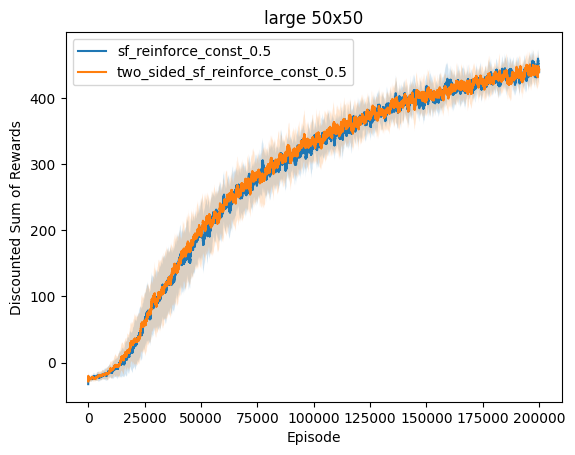

sf_reinforce_const_0.7 large
10 200000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
3,"[-0.39, -0.59, -0.13, -0.66, -0.17, -1.08]","[0.1, 2.99, 0.21, -2.81, -0.16, 1.97]","[-0.14, -2.25, -0.31, 4.11, -0.21, 0.41]","[0.43, -0.08, 0.11, -0.79, 0.43, -1.22]",-0.19,-0.34,0.09,-0.14,276.316375
1,"[0.05, -0.72, -0.24, -0.26, -0.38, -1.08]","[-0.1, 2.76, 0.07, -2.71, 0.09, 1.98]","[0.06, -1.89, 0.06, 3.77, 0.09, 0.26]","[0.47, -0.3, -0.23, -0.68, -0.04, -1.07]",-0.30,0.31,0.37,0.06,273.692560
6,"[0.14, -0.49, 0.27, -0.54, -0.24, -1.07]","[0.11, 2.97, -0.01, -2.88, -0.34, 2.31]","[0.22, -1.61, -0.2, 4.05, 0.03, 0.11]","[-0.22, -0.45, -0.49, -0.72, -0.0, -0.91]",-0.08,0.02,-0.12,-0.03,273.410659
4,"[0.16, -0.21, -0.37, -0.67, -0.4, -1.35]","[0.45, 2.88, 0.28, -2.75, -0.07, 1.77]","[0.32, -1.94, 0.16, 4.03, 0.07, -0.07]","[-0.4, -0.6, 0.07, -0.57, 0.22, -1.26]",0.35,0.03,0.55,-0.12,271.500808
8,"[0.22, -0.54, 0.28, -1.02, -0.2, -1.05]","[0.3, 2.19, 0.22, -2.82, 0.52, 2.33]","[-0.22, -1.9, -0.71, 4.14, 0.17, -0.31]","[-0.23, -0.62, -0.55, -0.57, -0.36, -1.16]",0.05,-0.18,-0.05,-0.07,261.597042
9,"[0.13, -0.48, 0.03, -0.29, 0.43, -0.9]","[-0.21, 2.7, -0.16, -2.22, 0.43, 1.99]","[-0.17, -1.52, -0.02, 3.56, 0.05, 0.54]","[-0.19, -0.48, 0.21, -0.29, 0.26, -0.95]",-0.21,-0.38,0.68,0.15,240.876957
0,"[-0.06, -0.08, -0.34, -0.76, -0.27, -1.11]","[0.01, 2.85, 0.07, -2.46, -0.19, 1.87]","[-0.42, -1.77, -0.1, 3.49, 0.06, 0.65]","[-0.35, -0.72, -0.07, -0.23, -0.03, -1.1]",-0.19,0.16,0.54,-0.55,235.657232
5,"[0.35, -0.6, 0.29, -0.21, 0.27, -1.03]","[-0.2, 2.7, -0.31, -2.02, 0.17, 1.77]","[-0.35, -1.58, 0.42, 3.47, 0.46, 0.61]","[-0.46, -0.2, 0.06, -0.48, -0.42, -0.98]",0.17,-0.33,0.46,-0.05,232.984001
7,"[0.01, -0.66, 0.02, -0.39, -0.31, -1.02]","[-0.3, 2.02, -0.07, -1.84, 0.31, 1.53]","[-0.27, -1.43, 0.06, 2.83, 0.11, 0.39]","[0.41, -0.82, 0.27, -0.55, 0.12, -0.96]",0.01,0.13,0.35,-0.07,191.220148
2,"[0.17, -0.36, -0.01, -0.63, 0.11, -0.95]","[0.11, 1.75, 0.15, -1.8, 0.12, 1.98]","[0.01, -0.98, -0.01, 3.14, 0.11, -0.07]","[-0.3, -0.15, -0.48, -0.71, -0.03, -0.88]",-0.20,0.16,0.15,-0.39,180.771844


two_sided_sf_reinforce_const_0.7 large
10 200000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
6,"[-0.01, -0.33, 0.37, -0.51, -0.22, -1.11]","[0.25, 2.83, 0.05, -2.81, -0.16, 2.15]","[0.11, -1.78, -0.12, 3.84, 0.3, 0.24]","[-0.11, -0.53, -0.26, -0.71, -0.19, -0.94]",-0.07,0.07,0.01,0.13,285.922285
3,"[-0.45, -0.63, -0.19, -0.6, 0.07, -1.08]","[0.29, 2.91, 0.05, -2.74, 0.02, 1.89]","[-0.18, -2.02, -0.32, 3.81, -0.2, 0.4]","[0.24, -0.12, 0.03, -0.7, 0.33, -1.24]",-0.38,-0.10,0.03,-0.11,272.407968
8,"[0.08, -0.33, 0.33, -0.89, -0.03, -1.06]","[0.34, 2.23, 0.14, -2.71, 0.42, 2.28]","[-0.22, -1.93, -0.29, 4.05, 0.28, -0.12]","[-0.02, -0.7, -0.29, -0.67, -0.35, -1.05]",0.03,-0.18,0.07,-0.15,264.453838
4,"[0.03, -0.34, -0.34, -0.59, -0.39, -1.33]","[0.39, 2.8, 0.09, -2.53, -0.15, 1.69]","[0.33, -1.86, 0.16, 3.93, 0.23, 0.01]","[-0.14, -0.7, -0.04, -0.49, 0.02, -1.25]",0.17,0.21,0.38,-0.09,259.237718
1,"[0.12, -0.59, -0.14, -0.42, -0.39, -1.05]","[-0.08, 2.73, 0.06, -2.55, 0.14, 1.88]","[0.1, -1.78, 0.03, 3.56, 0.1, 0.38]","[0.33, -0.25, -0.23, -0.69, -0.06, -1.15]",-0.27,0.11,0.48,0.10,253.705295
0,"[0.01, -0.26, -0.35, -0.7, -0.16, -0.95]","[0.11, 2.86, -0.07, -2.37, -0.16, 1.76]","[-0.35, -1.85, -0.04, 3.44, 0.15, 0.73]","[-0.34, -0.66, 0.11, -0.22, -0.09, -0.99]",-0.24,0.09,0.52,-0.52,252.682452
5,"[0.27, -0.56, 0.28, -0.21, 0.41, -1.13]","[-0.28, 2.55, -0.38, -2.12, 0.12, 1.79]","[-0.3, -1.47, 0.23, 3.45, 0.46, 0.35]","[-0.4, -0.04, 0.04, -0.66, -0.43, -1.02]",0.19,-0.25,0.26,-0.05,229.394339
9,"[0.17, -0.56, -0.12, -0.41, 0.32, -0.89]","[-0.18, 2.63, -0.02, -2.26, 0.43, 1.91]","[-0.28, -1.58, 0.06, 3.36, 0.08, 0.59]","[-0.12, -0.38, 0.12, -0.36, 0.25, -0.97]",-0.20,-0.23,0.48,0.10,211.148997
7,"[0.01, -0.58, 0.08, -0.4, -0.2, -1.08]","[-0.25, 2.01, -0.06, -1.84, 0.28, 1.64]","[-0.24, -1.5, 0.05, 3.12, 0.2, 0.29]","[0.38, -0.65, 0.26, -0.55, 0.18, -1.04]",-0.07,0.21,0.36,0.02,202.664845
2,"[0.11, -0.44, 0.06, -0.7, 0.19, -0.89]","[-0.05, 1.69, 0.13, -1.89, 0.08, 2.02]","[-0.07, -0.86, 0.08, 3.05, 0.17, -0.2]","[-0.16, -0.13, -0.43, -0.74, -0.03, -0.91]",-0.06,0.23,-0.01,-0.27,181.735714


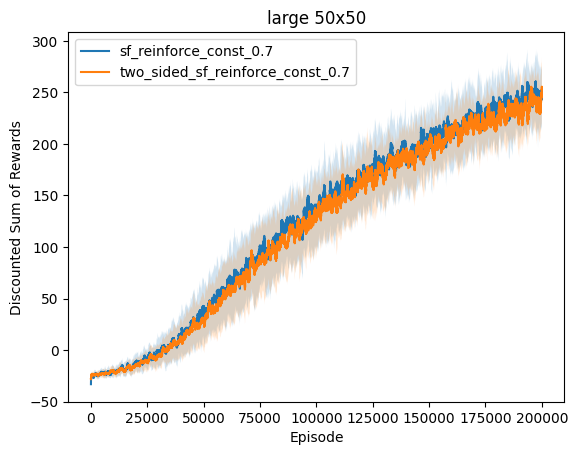

In [15]:
gridsizes = ["4x4", "8x8", "10x10", "20x20", "50x50"]
for grid, gridsize in zip(["large"], ["50x50"]):
    for suffix in "const_0.175 const_0.5 const_0.7".split():
        for algo in "sf_reinforce two_sided_sf_reinforce".split():
            name = algo + "_" + suffix
            dirname = os.path.join("saves", name, grid)
            filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
            path = os.path.join(dirname, filename)
            print(name, grid)
            avg_rewards, bot, top = get_results(path, 800)
            plt.plot(avg_rewards, label=name)
            plt.fill_between(range(len(avg_rewards)), bot, top, alpha=0.2)
        plt.title(f"{grid} {gridsize}")
        plt.xlabel('Episode')
        plt.ylabel('Discounted Sum of Rewards')
        plt.legend()
        plt.show()


In [5]:
keys = [
    algo + "_" + suffix
        for algo in "sf_reinforce_signed two_sided_sf_reinforce_signed".split()
    for suffix in "const_0.175 const_0.175_small_alpha".split()
]

keys

['sf_reinforce_signed_const_0.175',
 'sf_reinforce_signed_const_0.175_small_alpha',
 'two_sided_sf_reinforce_signed_const_0.175',
 'two_sided_sf_reinforce_signed_const_0.175_small_alpha']

sf_reinforce_signed_const_0.175 large
10 200000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
1,"[-0.37, -2.16, -3.73, 0.77, 6.61, -4.26]","[-0.61, 0.67, 0.57, 0.42, -4.99, 7.21]","[0.54, -2.1, 3.18, 8.81, -0.09, 1.71]","[4.27, 0.98, -1.73, 4.32, 4.1, -1.85]",3.40,1.64,2.38,0.87,648.796327
7,"[2.66, -2.07, -4.42, -1.7, 1.71, -7.59]","[1.13, 1.66, -4.03, -6.97, 0.67, 5.07]","[0.24, -3.62, 7.26, 5.02, 6.83, -0.92]","[4.48, -2.38, -3.86, -2.02, 0.25, -0.14]",-5.96,4.21,5.02,-0.81,637.991059
6,"[0.86, -2.78, -9.82, 0.29, -1.86, -3.0]","[5.59, 4.62, -6.31, -3.88, 0.23, 4.54]","[-0.2, 1.52, -2.66, 5.15, -1.43, -1.02]","[7.62, 0.09, -1.06, -4.73, 6.81, 1.28]",-5.28,-1.99,4.80,5.90,631.975322
0,"[0.55, -5.01, -3.47, 2.95, -2.82, 2.49]","[0.08, 6.08, 2.81, -2.9, -0.15, 3.46]","[3.87, -3.4, -3.02, 3.83, 0.05, 6.59]","[0.13, -3.26, -5.09, -0.26, -4.11, -3.39]",-0.20,5.24,4.30,-0.16,537.625283
3,"[7.49, -3.9, -4.78, -8.5, -3.47, -5.15]","[1.84, 1.94, -0.41, -0.88, 8.32, 1.51]","[2.09, -6.69, 2.79, 2.38, -1.2, 6.39]","[1.81, -3.62, -4.48, 4.15, 5.76, 0.19]",-0.52,3.07,1.43,5.61,537.418517
2,"[-1.12, 3.16, -7.99, -1.31, -7.62, -1.32]","[0.39, 12.22, -6.17, -10.88, -3.35, 2.8]","[0.28, -1.88, 1.98, 1.49, 2.09, 3.1]","[1.3, -1.53, -4.93, 6.4, -4.18, -3.18]",1.30,-2.19,-0.75,1.85,465.328808
8,"[-1.78, -4.46, 7.19, -2.15, -3.47, -2.25]","[1.74, -5.89, 3.6, -5.94, 2.42, 11.77]","[2.11, 4.05, -1.11, 2.6, -2.04, -4.63]","[3.82, 0.14, -4.37, -3.85, 2.63, -10.07]",1.63,-3.29,1.45,-5.18,357.198355
5,"[2.57, 1.11, 3.33, 1.13, 3.74, -2.55]","[-4.14, 9.07, -3.52, 9.48, -1.35, -3.6]","[2.96, -4.53, -2.58, 2.74, 4.28, 8.67]","[-3.16, 2.3, -6.24, 4.44, 1.99, 0.07]",-5.98,-2.30,2.41,0.40,344.630072
9,"[-1.22, -1.01, -4.48, -0.56, 0.54, -4.99]","[6.49, 4.99, 7.18, -2.24, 7.97, 5.65]","[1.73, -1.18, 1.33, 2.38, -1.48, -8.01]","[0.49, 1.23, -0.74, -1.06, 6.97, 2.76]",-4.99,1.32,2.23,0.68,-20.990376
4,"[1.14, 7.01, -3.21, -0.82, 8.6, 5.45]","[6.57, 6.62, -3.43, 8.47, -2.26, -4.68]","[-1.16, 4.1, 2.58, -6.43, 2.41, -6.68]","[-0.44, -3.86, -3.16, -0.69, -2.69, -4.64]",-5.71,-0.56,-6.04,-0.12,-23.979995


two_sided_sf_reinforce_signed_const_0.175 large
10 200000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
6,"[-9.1, -1.72, 3.36, -1.73, 1.5, 1.58]","[-1.36, 12.78, -1.13, -8.63, 5.13, 5.59]","[-0.93, -7.21, 1.71, 19.27, 3.86, -2.11]","[3.15, -1.29, -7.72, -8.86, 0.85, 2.66]",-4.98,2.86,0.12,-1.31,828.879772
5,"[-2.86, -2.47, -5.17, 0.89, 1.97, -4.7]","[-1.39, 14.08, 3.69, -7.05, -4.85, -2.34]","[6.66, -6.11, 2.62, 16.61, -3.04, -5.87]","[-3.65, -3.43, 2.44, 0.65, 0.35, -4.5]",-5.29,-2.26,3.81,-4.11,826.667247
3,"[-2.7, -1.29, -0.77, -2.79, 2.35, -5.39]","[8.57, 12.6, 1.59, -6.23, 1.07, 6.71]","[-1.07, -5.71, 1.82, 16.28, 0.3, 2.94]","[3.82, 1.13, 2.11, -8.34, 5.05, -0.87]",-9.04,0.05,0.70,-4.21,826.195269
9,"[-1.1, -5.98, 0.01, -1.55, 5.24, 0.8]","[-4.06, 8.35, 4.52, -10.27, -0.98, 9.02]","[9.57, -8.8, -2.5, 15.07, -1.43, 1.15]","[-3.43, -2.72, 1.46, 4.43, 2.27, -4.12]",2.34,3.57,9.97,1.50,826.166676
7,"[-7.97, 1.96, 3.75, 1.36, 0.59, 0.68]","[1.52, 10.59, -2.84, -6.42, 2.15, 7.41]","[0.46, 1.1, 4.55, 17.69, 1.5, -6.56]","[-5.9, -3.38, -5.86, -1.61, 4.2, -0.5]",2.59,-0.64,9.12,-0.36,825.258689
4,"[-4.14, 5.02, -3.63, 1.55, 3.35, 0.76]","[0.32, 13.65, 4.34, -5.37, 1.14, 3.68]","[4.41, -12.29, 5.92, 11.5, 0.34, 12.28]","[2.79, 1.76, -9.36, 1.24, -2.71, -0.19]",-1.46,8.30,-2.95,-0.07,822.726798
1,"[-4.39, 1.17, -2.84, 1.55, 8.7, -5.96]","[2.54, 9.98, 5.69, -7.38, 6.53, 0.25]","[6.19, -14.45, 0.97, 8.6, 2.19, 8.38]","[0.33, 1.92, 0.55, -3.11, 2.57, -5.79]",-3.21,-3.60,2.67,-6.92,822.648517
0,"[6.73, -1.19, 2.41, -5.48, -3.67, 1.81]","[-2.47, 10.83, 3.42, -6.53, 1.18, -1.19]","[-0.58, -11.95, -8.8, 8.58, -4.36, 6.24]","[-3.35, -5.33, -0.81, 5.1, -2.79, -2.19]",-5.78,-6.79,-1.68,-6.10,821.786633
2,"[6.44, -0.25, -3.06, -0.01, 3.16, -2.65]","[-10.64, 12.47, -4.97, -7.57, 3.23, 9.05]","[1.24, -2.91, -0.01, 15.89, -3.33, 0.98]","[2.2, -1.23, -0.25, 0.61, 5.6, -3.37]",-2.54,6.93,6.90,-2.93,820.988583
8,"[1.19, 3.09, 3.73, -1.29, -8.1, -1.2]","[0.55, 14.27, -0.89, -7.82, 1.37, 3.38]","[-2.28, -3.82, 2.35, 10.59, -2.13, 3.06]","[-2.04, 4.37, -6.39, -0.1, -1.94, -1.96]",1.18,5.64,3.29,1.41,820.088829


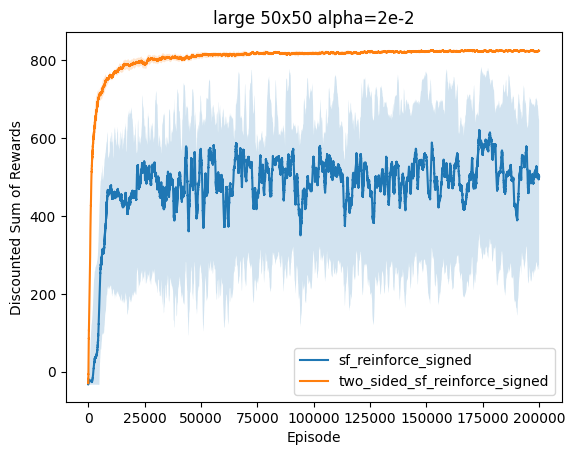

sf_reinforce_signed_const_0.175_medium_alpha large
10 200000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
6,"[0.08, 0.0, 0.36, -0.06, -0.2, -0.22]","[0.15, 0.93, 0.04, -0.86, -0.19, 0.68]","[0.13, -0.37, -0.21, 1.12, 0.3, 0.06]","[-0.16, -0.25, -0.26, -0.3, -0.12, -0.07]",0.02,-0.12,-0.16,0.26,295.326006
1,"[0.24, -0.36, -0.06, 0.04, -0.37, -0.2]","[-0.08, 0.82, 0.05, -0.76, 0.14, 0.47]","[0.18, -0.55, 0.03, 0.9, 0.09, 0.2]","[0.33, 0.03, -0.16, -0.25, -0.05, -0.32]",-0.18,0.03,0.23,0.23,276.998243
8,"[0.1, 0.08, 0.31, -0.46, 0.06, -0.23]","[0.38, 0.32, 0.03, -0.72, 0.34, 0.76]","[-0.22, -0.57, -0.35, 1.19, 0.19, -0.15]","[-0.04, -0.32, -0.25, -0.14, -0.37, -0.19]",0.21,-0.32,-0.11,-0.05,268.588342
4,"[0.13, 0.06, -0.31, -0.23, -0.41, -0.43]","[0.48, 0.91, 0.1, -0.52, -0.11, 0.2]","[0.36, -0.56, 0.06, 1.18, 0.16, -0.02]","[-0.21, -0.45, 0.03, -0.18, 0.12, -0.32]",0.35,0.04,0.23,0.14,263.034340
0,"[-0.04, -0.0, -0.29, -0.35, -0.21, -0.11]","[0.05, 1.04, 0.0, -0.48, -0.11, 0.29]","[-0.37, -0.58, -0.12, 0.81, 0.1, 0.58]","[-0.27, -0.35, 0.16, 0.17, -0.09, -0.03]",-0.01,0.06,0.45,-0.40,249.803154
3,"[-0.4, -0.35, -0.16, -0.39, 0.0, -0.33]","[0.19, 0.75, 0.11, 0.03, -0.03, -0.12]","[-0.28, -0.54, -0.38, 0.32, -0.24, 0.79]","[0.32, 0.22, 0.11, -0.18, 0.34, -0.46]",-0.32,-0.27,-0.15,0.02,89.300457
5,"[0.28, -0.26, 0.39, 0.21, 0.34, -0.36]","[-0.29, 0.57, -0.43, 0.48, 0.13, -0.03]","[-0.37, -0.05, 0.18, 0.07, 0.38, 0.52]","[-0.35, 0.11, 0.25, -0.16, -0.38, -0.06]",0.36,-0.31,0.12,0.10,9.843177
7,"[0.05, -0.19, 0.15, 0.12, -0.25, -0.13]","[-0.25, 0.18, -0.07, 0.3, 0.32, 0.02]","[-0.19, -0.18, -0.12, -0.1, 0.2, -0.34]","[0.4, -0.34, 0.28, -0.07, 0.11, 0.15]",0.00,0.13,0.33,0.11,-28.319859
2,"[0.13, -0.09, 0.12, 0.01, 0.18, 0.14]","[-0.01, -0.26, 0.14, -0.34, 0.06, 0.02]","[0.02, 0.29, -0.02, 0.15, 0.18, -0.24]","[-0.2, 0.48, -0.41, -0.11, -0.03, 0.23]",-0.07,0.10,-0.02,-0.24,-32.640716
9,"[0.08, -0.17, -0.03, 0.15, 0.37, 0.35]","[-0.17, 0.34, -0.11, -0.06, 0.4, 0.1]","[-0.25, -0.24, 0.03, -0.03, -0.01, -0.16]","[-0.05, 0.1, 0.18, 0.17, 0.29, 0.21]",-0.11,-0.36,0.33,0.24,-32.984912


two_sided_sf_reinforce_signed_const_0.175_medium_alpha large
10 200000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
6,"[-0.01, 0.01, 0.26, -0.19, -0.19, -0.31]","[0.18, 1.7, 0.09, -1.87, -0.09, 0.95]","[0.11, -1.18, -0.06, 2.17, 0.33, -0.13]","[-0.07, -0.16, -0.38, -0.26, -0.16, -0.18]",-0.22,0.06,0.04,-0.07,536.017746
4,"[0.1, 0.04, -0.32, -0.28, -0.36, -0.45]","[0.45, 1.71, 0.08, -1.55, -0.16, 0.48]","[0.36, -1.34, 0.11, 2.26, 0.24, -0.24]","[-0.14, -0.42, -0.07, -0.19, 0.08, -0.41]",0.10,0.21,0.55,-0.04,530.909097
9,"[0.16, -0.16, -0.08, -0.03, 0.35, -0.12]","[-0.2, 1.48, -0.01, -1.59, 0.3, 1.04]","[-0.34, -1.18, 0.11, 2.31, 0.13, -0.13]","[-0.08, -0.01, 0.02, -0.13, 0.21, -0.18]",-0.32,-0.26,0.64,-0.03,520.587114
3,"[-0.5, -0.26, -0.24, -0.39, -0.04, -0.4]","[0.26, 1.76, 0.11, -1.72, -0.07, 0.55]","[-0.21, -1.55, -0.23, 1.93, -0.22, 0.24]","[0.28, 0.2, 0.05, -0.34, 0.2, -0.53]",-0.47,-0.16,0.29,-0.25,520.546973
1,"[0.22, -0.26, -0.1, -0.11, -0.38, -0.23]","[-0.03, 1.64, 0.06, -1.71, 0.12, 0.74]","[0.19, -1.43, -0.0, 2.09, 0.09, 0.06]","[0.3, 0.03, -0.18, -0.33, -0.14, -0.35]",-0.27,0.18,0.54,-0.05,517.977742
8,"[0.06, 0.08, 0.37, -0.49, -0.09, -0.31]","[0.38, 1.04, 0.13, -1.77, 0.39, 1.13]","[-0.27, -1.4, -0.31, 2.32, 0.3, -0.4]","[-0.08, -0.4, -0.42, -0.21, -0.37, -0.19]",-0.02,-0.16,0.26,-0.25,512.817517
2,"[0.12, -0.13, 0.03, -0.29, 0.11, -0.27]","[-0.04, 1.1, 0.11, -1.8, 0.07, 1.25]","[-0.11, -0.82, 0.13, 2.12, 0.21, -0.62]","[-0.16, 0.16, -0.46, -0.33, -0.05, -0.33]",-0.32,0.26,0.20,-0.40,509.012667
0,"[0.01, 0.06, -0.38, -0.29, -0.2, -0.17]","[0.03, 1.87, 0.02, -1.54, -0.08, 0.57]","[-0.44, -1.53, -0.11, 2.01, 0.12, 0.45]","[-0.29, -0.27, 0.14, 0.06, -0.12, -0.2]",-0.19,0.05,0.60,-0.50,495.733942
5,"[0.3, -0.31, 0.29, 0.08, 0.31, -0.38]","[-0.34, 1.9, -0.39, -1.4, 0.08, 0.48]","[-0.35, -1.3, 0.28, 2.03, 0.48, 0.24]","[-0.39, 0.17, 0.07, -0.23, -0.37, -0.27]",0.08,-0.18,0.50,-0.10,491.109513
7,"[-0.03, -0.27, 0.04, -0.1, -0.21, -0.21]","[-0.21, 0.06, 0.16, 0.79, 0.49, 0.69]","[-0.13, -0.24, -0.04, -0.09, 0.25, -0.35]","[0.42, -0.38, 0.2, -0.32, -0.02, -0.3]",-0.47,0.70,0.83,-0.50,-20.971573


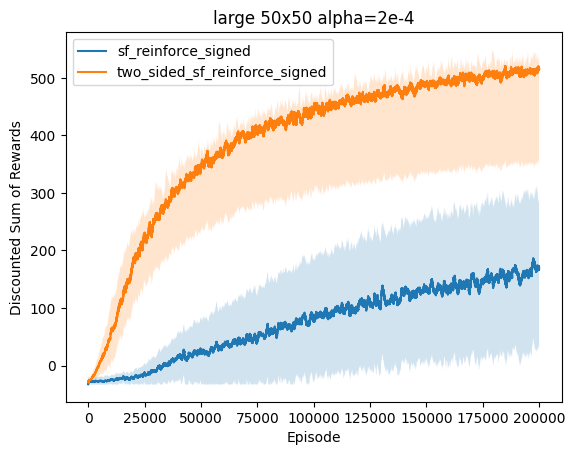

sf_reinforce_signed_const_0.175_small_alpha large
10 200000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
3,"[-0.4, -0.32, -0.17, -0.39, -0.02, -0.36]","[0.22, 0.2, 0.08, 0.32, -0.04, 0.24]","[-0.29, -0.08, -0.36, -0.03, -0.26, 0.37]","[0.28, 0.31, 0.12, -0.23, 0.37, -0.4]",-0.26,-0.26,-0.17,0.08,-8.395678
4,"[0.05, 0.05, -0.33, -0.24, -0.4, -0.38]","[0.4, 0.34, 0.1, 0.39, -0.15, -0.23]","[0.35, -0.02, 0.08, 0.24, 0.21, -0.23]","[-0.16, -0.38, 0.02, -0.15, 0.09, 0.02]",0.35,0.04,0.20,0.13,-21.226623
1,"[0.21, -0.18, -0.08, 0.19, -0.39, 0.24]","[-0.08, 0.21, 0.06, -0.05, 0.11, 0.02]","[0.15, -0.16, -0.03, -0.04, 0.06, 0.0]","[0.36, 0.13, -0.15, -0.25, -0.07, -0.18]",-0.13,0.02,0.24,0.22,-23.667143
6,"[0.06, 0.04, 0.4, 0.09, -0.22, -0.04]","[0.14, 0.2, 0.05, -0.27, -0.14, -0.03]","[0.11, 0.22, -0.23, 0.23, 0.3, 0.08]","[-0.11, -0.2, -0.27, -0.18, -0.09, 0.27]",0.10,-0.09,-0.25,0.28,-26.792937
0,"[-0.0, 0.22, -0.34, -0.3, -0.16, 0.11]","[-0.01, 0.32, -0.04, 0.11, -0.12, -0.08]","[-0.39, -0.27, -0.17, 0.02, 0.16, 0.25]","[-0.28, -0.18, 0.15, 0.34, -0.08, 0.3]",-0.07,0.04,0.37,-0.38,-27.299744
5,"[0.27, -0.31, 0.33, 0.26, 0.34, -0.31]","[-0.27, 0.2, -0.38, 0.4, 0.09, 0.05]","[-0.35, 0.13, 0.18, 0.07, 0.39, 0.12]","[-0.36, 0.34, 0.14, -0.19, -0.38, 0.23]",0.39,-0.33,0.02,0.15,-28.457203
7,"[0.03, -0.25, 0.13, 0.13, -0.22, -0.06]","[-0.24, 0.11, -0.11, 0.29, 0.29, 0.04]","[-0.17, -0.24, -0.05, -0.11, 0.18, -0.35]","[0.38, -0.32, 0.31, -0.07, 0.21, 0.16]",0.02,0.08,0.31,0.10,-28.835310
8,"[0.08, 0.28, 0.36, -0.17, 0.01, 0.12]","[0.33, -0.4, 0.06, -0.31, 0.34, 0.15]","[-0.24, -0.32, -0.41, 0.32, 0.25, -0.2]","[-0.03, -0.27, -0.27, 0.01, -0.32, 0.07]",0.24,-0.34,-0.11,-0.02,-30.258951
2,"[0.09, -0.1, 0.11, -0.02, 0.17, 0.1]","[-0.05, -0.33, 0.09, -0.36, 0.05, 0.03]","[-0.09, 0.33, 0.03, 0.17, 0.17, -0.24]","[-0.16, 0.39, -0.4, -0.03, -0.03, 0.29]",-0.04,0.11,-0.02,-0.23,-32.620227
9,"[0.13, -0.16, -0.02, 0.23, 0.34, 0.35]","[-0.2, 0.37, -0.1, -0.07, 0.37, 0.06]","[-0.3, -0.24, 0.01, -0.01, 0.02, -0.13]","[-0.04, 0.11, 0.16, 0.26, 0.34, 0.19]",-0.04,-0.35,0.34,0.23,-33.291228


two_sided_sf_reinforce_signed_const_0.175_small_alpha large
10 200000


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
3,"[-0.41, -0.32, -0.18, -0.39, -0.02, -0.36]","[0.22, 0.23, 0.08, 0.31, -0.04, 0.23]","[-0.29, -0.11, -0.36, -0.02, -0.26, 0.39]","[0.28, 0.3, 0.12, -0.24, 0.36, -0.41]",-0.26,-0.25,-0.16,0.07,-7.420865
4,"[0.05, 0.05, -0.33, -0.24, -0.4, -0.38]","[0.4, 0.34, 0.1, 0.4, -0.15, -0.19]","[0.35, -0.02, 0.07, 0.23, 0.21, -0.2]","[-0.16, -0.38, 0.02, -0.15, 0.09, -0.07]",0.35,0.04,0.20,0.13,-18.792999
6,"[0.06, 0.04, 0.4, 0.09, -0.22, -0.05]","[0.14, 0.2, 0.05, -0.27, -0.14, -0.01]","[0.11, 0.23, -0.23, 0.23, 0.3, 0.16]","[-0.11, -0.21, -0.28, -0.18, -0.09, 0.19]",0.10,-0.09,-0.25,0.27,-19.744677
0,"[-0.0, 0.22, -0.34, -0.3, -0.16, 0.08]","[-0.01, 0.32, -0.03, 0.11, -0.12, -0.07]","[-0.39, -0.26, -0.17, 0.02, 0.16, 0.33]","[-0.28, -0.19, 0.15, 0.33, -0.08, 0.25]",-0.07,0.04,0.37,-0.38,-20.855346
5,"[0.27, -0.31, 0.33, 0.25, 0.34, -0.32]","[-0.27, 0.2, -0.38, 0.42, 0.09, 0.09]","[-0.35, 0.14, 0.17, 0.06, 0.39, 0.17]","[-0.36, 0.33, 0.14, -0.2, -0.38, 0.14]",0.39,-0.33,0.02,0.15,-23.866217
8,"[0.08, 0.28, 0.36, -0.18, 0.01, 0.07]","[0.33, -0.39, 0.07, -0.29, 0.34, 0.23]","[-0.24, -0.32, -0.4, 0.33, 0.25, -0.19]","[-0.03, -0.27, -0.27, -0.01, -0.32, 0.03]",0.23,-0.34,-0.11,-0.02,-23.969834
1,"[0.21, -0.18, -0.09, 0.15, -0.39, 0.19]","[-0.08, 0.21, 0.07, 0.01, 0.12, 0.04]","[0.15, -0.15, -0.03, -0.04, 0.06, 0.03]","[0.36, 0.13, -0.15, -0.25, -0.07, -0.18]",-0.13,0.03,0.24,0.22,-25.363736
7,"[0.03, -0.25, 0.13, 0.1, -0.22, -0.06]","[-0.24, 0.11, -0.1, 0.33, 0.29, 0.1]","[-0.17, -0.24, -0.05, -0.12, 0.18, -0.35]","[0.38, -0.32, 0.31, -0.09, 0.21, 0.1]",0.02,0.08,0.31,0.10,-26.255167
2,"[0.09, -0.1, 0.11, -0.01, 0.17, 0.1]","[-0.05, -0.33, 0.1, -0.34, 0.06, 0.07]","[-0.09, 0.33, 0.03, 0.17, 0.17, -0.24]","[-0.16, 0.39, -0.41, -0.06, -0.04, 0.24]",-0.04,0.12,-0.02,-0.23,-32.382081
9,"[0.13, -0.16, -0.01, 0.24, 0.34, 0.28]","[-0.2, 0.37, -0.09, -0.06, 0.37, 0.08]","[-0.3, -0.24, 0.02, -0.01, 0.02, -0.12]","[-0.04, 0.11, 0.14, 0.23, 0.33, 0.22]",-0.04,-0.34,0.34,0.22,-32.608731


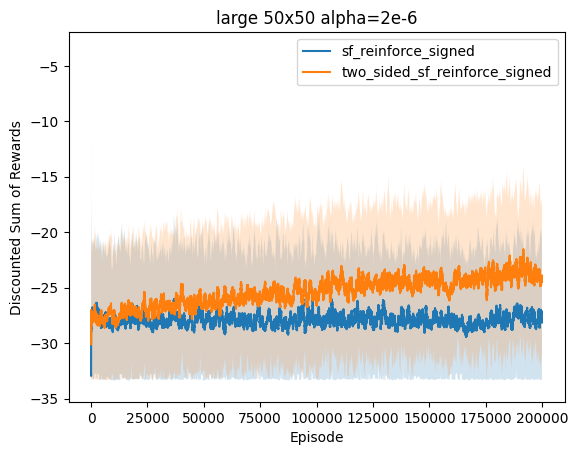

In [3]:
# mapping = dict(zip(['sf_reinforce_signed_const_0.175',
#  'sf_reinforce_signed_const_0.175_small_alpha',
#  'two_sided_sf_reinforce_signed_const_0.175',
#  'two_sided_sf_reinforce_signed_const_0.175_small_alpha'], ["sf_reinforce_signed_alpha_2e-4"]))
for grid, gridsize in zip(["large"], ["50x50"]):
    for suffix in "const_0.175 const_0.175_medium_alpha const_0.175_small_alpha".split():
        for algo in "sf_reinforce_signed two_sided_sf_reinforce_signed".split():
            name = algo + "_" + suffix
            dirname = os.path.join("saves", name, grid)
            filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
            path = os.path.join(dirname, filename)
            print(name, grid)
            avg_rewards, bot, top = get_results(path, 800)
            plt.plot(avg_rewards, label=algo)
            plt.fill_between(range(len(avg_rewards)), bot, top, alpha=0.2)

        plt.title(f"{grid} {gridsize} alpha=" + ("2e-6" if "small" in suffix else "2e-4" if "medium" in suffix else "2e-2"))
        plt.xlabel('Episode')
        plt.ylabel('Discounted Sum of Rewards')
        plt.legend()
        plt.show()
